In [ ]:
# # Wikipedia2vec stuff:
# from wikipedia2vec import Wikipedia2Vec
# wiki2vec = Wikipedia2Vec.load("models/enwiki_20180420_win10_100d.pkl")

In [1]:
import torch
import wikipedia
from tqdm import tqdm

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

In [3]:
# read in DHS survey cluster loc data
rwanda_clusters_loc =  pd.read_csv("data/Rwanda/rwanda_clusters_location.csv")
rwanda_clusters_loc = rwanda_clusters_loc[['DHSCLUST', 'LATNUM', 'LONGNUM']] # columns required
rwanda_clusters_loc.columns = ['cluster', 'latitude', 'longitude'] # rename required columns

# read survey data
data_hh = pd.read_stata('data/Rwanda/Rwanda-DHS-2010/RW_2010_DHS_02192021_2229_158318/RWHR61DT/RWHR61FL.DTA') # takes a while
data_hh_names = list(data_hh.columns) # read in DHS survey data for wealth index factor
wealth_by_clust = data_hh.groupby('hv001').mean() # get mean of all variables by cluster ID
wealth_by_clust.index = range(0, 492) # set index properly
wealth_by_clust['hv001'] = range(1, 493) # fix cluster ID variable

# use non-normalized wealth score to match with the provided results
wealth_by_clust['hv271_decimal'] = wealth_by_clust['hv271']/100000  # divide by 100000 to match with the 5-decimal provided form
wealth_by_clust = wealth_by_clust[['hv001', 'hv271_decimal']] # keep required columns
wealth_by_clust.columns = ['cluster', 'cluster_wealth_mean'] # rename columns


rwanda_cluster_avg_asset_2010 = rwanda_clusters_loc.merge(wealth_by_clust, # merge
                                                           left_on='cluster', right_on='cluster')
rwanda_cluster_avg_asset_2010.to_csv('data/Rwanda/outputs/rwanda_cluster_avg_asset_2010.csv', index=False) # write to disk
rwanda_cluster_avg_asset_2010.head(5)

,cluster,latitude,longitude,cluster_wealth_mean
0,1.0,-2.532818,29.684726,-0.386620
1,2.0,-1.833858,30.310689,-0.421574
2,3.0,-1.888155,29.478298,-0.449724
3,4.0,-2.366763,30.521692,-0.390006
4,5.0,-2.171266,30.018541,-0.416924


In [12]:
def get_all_articles_near_clust(clust, already_obtained={}, 
                                keep_content=False, get_embeddings=False, model_funct=None):
    '''
    Function for getting all of the wikipedia articles near a given cluster 
    (within a radius of 10 km)
    '''
    lat = clust['latitude']
    lng = clust['longitude']
    article_titles = wikipedia.geosearch(lat, lng, results=1000, radius=10000)
    pages_info = {}
    for article_title in article_titles:
        if article_title not in already_obtained:
            page = wikipedia.page(article_title, auto_suggest=False)
            print(f"Processing {page.title}")
            pages_info[page.title]={'latitude' : page.coordinates[0], 
                                     'longitude': page.coordinates[1]}
            if keep_content:
                pages_info[page.title]['text'] = page.content
            
            if get_embeddings:
                pages_info[page.title]['embedding'] = model_funct(page.content) #model_funct(page.title)
    return pages_info

#### Load ERNIE Model

In [9]:
# ERNIE:
from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained("nghuyong/ernie-2.0-en")
model = AutoModel.from_pretrained("nghuyong/ernie-2.0-en")

In [55]:
def get_article_embedding(content, tokenizer, model):
    '''
    Get vector embedding from the text of an article. 
    
    Args:
    content: str. 
             the text of teh article
    
    tokenizer: transformers tokenizer.
    
    mode: transformers model (assumed to be ERNIE or BERT-like).
    
    Returns:
    embeds: a torch tensor representing the document vector. 
    '''
    # Split article into sentences
    sents = content.split(".")
    embeds = []
    # Do not copmpute model gradients
    with torch.no_grad():
        # Iterate over sentences
        for sent in sents: #tqdm(sents, desc="Sentence Progress:"):
            try:
                # Encode the model using the tokenizer and then run the model
                encoded_input = tokenizer(sent, return_tensors='pt')
                output = model(**encoded_input)
                # Get vector embedding for the CLS token of the sentence
                class_embedding = output.last_hidden_state[0, 0,:]
                # Assemble a list of sentence embeddings 
                embeds.append(class_embedding)
            except:
                try:
                    split_sents = sent.split(' ')
                    sent1 = ' '.join(split_sents[:len(split_sents)//2])
                    sent2 = ' '.join(split_sents[len(split_sents)//2:])
                    # Encode the model using the tokenizer and then run the model
                    encoded_input = tokenizer(sent1, return_tensors='pt')
                    output = model(**encoded_input)
                    # Get vector embedding for the CLS token of the sentence
                    class_embedding = output.last_hidden_state[0, 0,:]
                    # Assemble a list of sentence embeddings 
                    embeds.append(class_embedding)
                    
                    # Encode the model using the tokenizer and then run the model
                    encoded_input = tokenizer(sent2, return_tensors='pt')
                    output = model(**encoded_input)
                    # Get vector embedding for the CLS token of the sentence
                    class_embedding = output.last_hidden_state[0, 0,:]
                    # Assemble a list of sentence embeddings 
                    embeds.append(class_embedding)

                except Exception as e:
                    print(e)
                    
    # Global Max pool (maybe use some other aggregation function)
    embeds = torch.stack(embeds)
    embeds, _  = torch.max(embeds, 0)
    return embeds

### Rwanda

In [13]:
wiki_articles = {}
for i in tqdm(range(len(rwanda_cluster_avg_asset_2010)), desc="Cluster Progress:"):
    wiki_articles.update(get_all_articles_near_clust(rwanda_cluster_avg_asset_2010.iloc[i], 
                                                     already_obtained=wiki_articles, 
                                                     keep_content=True, get_embeddings=True, 
                                                     model_funct= lambda x: get_article_embedding(x, tokenizer, model)))

Cluster Progress::   0%|          | 0/492 [00:00<?, ?it/s]

Processing Maraba, Rwanda
Processing Huye District
Processing Mount Huye
Processing Butare Airport
Processing Stade Huye
Processing Save, Rwanda


Cluster Progress::   0%|          | 1/492 [00:08<1:12:27,  8.85s/it]

Processing Rwanda Cricket Stadium
Processing Kicukiro District
Processing École Technique Officielle
Processing Kigali International Airport
Processing Akagera Aviation School
Processing Amahoro Stadium
Processing Rwanda Development Board
Processing Nyamirambo
Processing Kigali Convention Centre
Processing Kigali Arena
Processing NCBA Bank Rwanda
Processing University of Global Health Equity
Processing Masaka, Rwanda
Processing Lycée de Kigali
Processing University of Kigali


Cluster Progress::   1%|          | 6/492 [00:45<1:08:06,  8.41s/it]

Processing Gakenke District


Cluster Progress::   1%|▏         | 7/492 [00:48<54:08,  6.70s/it]  

Processing Mbogo
Processing Rulindo District
Processing Ntarabana
Processing Rusiga
Processing Tare, Rwanda
Processing Tumba, Rwanda
Processing Shyorongi
Processing Murambi


Cluster Progress::   2%|▏         | 8/492 [01:03<1:14:22,  9.22s/it]

Processing King Faisal Hospital (Kigali)
Processing St. Ignatius School, Kigali
Processing Village Urugwiro
Processing Kigali International Community School
Processing List of ambassadors of China to Rwanda
Processing List of ambassadors of China to Samoa
Processing Nyarugenge
Processing Sainte-Famille Church
Processing Hôtel des Mille Collines
Processing Crystal Telecom Rwanda
Processing Kigali
Processing East Africa Exchange
Processing Kigali City Tower
Processing Rwanda Energy Group
Processing Gisimba Memorial Centre
Processing National Institute of Statistics of Rwanda
Processing Ndera
Processing Kandt House Museum of Natural History
Processing Roman Catholic Archdiocese of Kigali
Processing Nyamirambo Regional Stadium


Cluster Progress::   2%|▏         | 9/492 [02:22<4:03:35, 30.26s/it]

Processing Rwamagana Solar Power Station
Processing Lake Mugesera
Processing Rwamagana District


Cluster Progress::   2%|▏         | 12/492 [02:34<1:37:44, 12.22s/it]

Processing Karongi District


Cluster Progress::   3%|▎         | 14/492 [02:37<53:42,  6.74s/it]  

Processing Nyabarongo Power Station


Cluster Progress::   3%|▎         | 16/492 [02:42<34:02,  4.29s/it]

Processing Kabgayi
Processing Roman Catholic Diocese of Kabgayi
Processing Apostolic Vicariate of Ruanda
Processing Muhanga
Processing Muhanga District


Cluster Progress::   3%|▎         | 17/492 [03:04<1:16:58,  9.72s/it]

Processing Nyabihu District


Cluster Progress::   4%|▍         | 19/492 [03:11<49:26,  6.27s/it]  

Processing Nyanza, Rwanda


Cluster Progress::   4%|▍         | 21/492 [03:18<35:20,  4.50s/it]

Processing Ruhango
Processing Ruhango District


Cluster Progress::   4%|▍         | 22/492 [03:25<42:01,  5.37s/it]

Processing Masaka Inland Container Depot
Processing Masaka Hospital, Rwanda


Cluster Progress::   5%|▍         | 23/492 [03:32<46:07,  5.90s/it]

Processing Rubavu District
Processing Nyundo, Rubavu
Processing Gisenyi Airport
Processing Sebeya River


Cluster Progress::   5%|▍         | 24/492 [03:48<1:09:03,  8.85s/it]

Processing Lake Burera
Processing Cyanika
Processing Kyanika
Processing Mount Muhabura


Cluster Progress::   5%|▌         | 27/492 [04:01<39:02,  5.04s/it]  

Processing Busengo, Rwanda
Processing Burega


Cluster Progress::   6%|▌         | 28/492 [04:06<39:50,  5.15s/it]

Processing Nyarugenge District
Processing Geography of Rwanda
Processing Jabana


Cluster Progress::   6%|▌         | 29/492 [04:16<50:07,  6.50s/it]

Processing Kabarore
Processing Gatsibo District


Cluster Progress::   6%|▌         | 30/492 [04:24<54:23,  7.06s/it]

Processing Ngororero
Processing Ngororero District


Cluster Progress::   7%|▋         | 32/492 [04:31<38:41,  5.05s/it]

Processing Musha, Rwanda


Cluster Progress::   7%|▋         | 36/492 [04:36<14:35,  1.92s/it]

Processing Southern Province, Rwanda
Processing Roman Catholic Diocese of Butare
Processing National University of Rwanda
Processing Butare Province


Cluster Progress::   8%|▊         | 39/492 [04:49<19:56,  2.64s/it]

Processing Our Lady of Kibeho
Processing Kibeho


Cluster Progress::   8%|▊         | 40/492 [04:56<31:32,  4.19s/it]

Processing Bwakira, Rwanda
Processing Mbirurume River
Processing Mwogo River


Cluster Progress::   9%|▊         | 42/492 [05:07<31:43,  4.23s/it]

Processing Nyaruguru District


Cluster Progress::   9%|▊         | 43/492 [05:09<28:29,  3.81s/it]

Processing Masoro, Rwanda


Cluster Progress::   9%|▉         | 44/492 [05:13<27:30,  3.68s/it]

Processing Gicumbi District
Processing Byumba Province
Processing Byumba


Cluster Progress::   9%|▉         | 46/492 [05:21<26:23,  3.55s/it]

Processing Commune of Kabarore


Cluster Progress::  10%|▉         | 48/492 [05:25<18:55,  2.56s/it]

Processing Kivu 56 Power Station
Processing Maison St Benoit


Cluster Progress::  10%|▉         | 49/492 [05:30<26:26,  3.58s/it]

Processing Northern Province, Rwanda
Processing Mulindi


Cluster Progress::  10%|█         | 51/492 [05:38<24:39,  3.36s/it]

Processing Gasabo District


Cluster Progress::  11%|█         | 54/492 [05:46<18:02,  2.47s/it]

Processing Kabarondo, Rwanda


Cluster Progress::  12%|█▏        | 57/492 [05:51<12:28,  1.72s/it]

Processing Buberuka Highlands


Cluster Progress::  12%|█▏        | 58/492 [05:55<17:41,  2.45s/it]

Processing Eastern Province, Rwanda


Cluster Progress::  12%|█▏        | 59/492 [05:57<17:34,  2.43s/it]

Processing Gisenyi
Processing Hewa Bora Airways Flight 122
Processing 2019 Busy Bee Congo crash
Processing Goma
Processing 2013 Compagnie Africaine d'Aviation Fokker 50 crash
Processing Gasmeth Energy Gas Works
Processing Goma (commune)
Processing Rubona, Rwanda
Processing Adventist University of Goma


Cluster Progress::  12%|█▏        | 60/492 [06:26<1:13:55, 10.27s/it]

Processing Lake Cohoha
Processing Nemba Airport
Processing Commune of Bugabira


Cluster Progress::  12%|█▏        | 61/492 [06:33<1:06:30,  9.26s/it]

Processing Buyoga


Cluster Progress::  13%|█▎        | 62/492 [06:35<50:08,  7.00s/it]  

Processing Gatunda


Cluster Progress::  13%|█▎        | 64/492 [06:38<30:09,  4.23s/it]

Processing Rusumo District
Processing Nyarubuye District


Cluster Progress::  14%|█▎        | 67/492 [06:44<17:06,  2.41s/it]

Processing Gatuna
Processing Katuna
Processing Muvumbe Hydroelectric Power Station


Cluster Progress::  14%|█▍        | 69/492 [06:57<27:19,  3.88s/it]

Processing Kabuga


Cluster Progress::  14%|█▍        | 70/492 [06:59<23:16,  3.31s/it]

Processing Rugezi Marsh


Cluster Progress::  15%|█▍        | 72/492 [07:03<17:29,  2.50s/it]

Processing Mount Karisimbi
Processing Mount Mikeno


Cluster Progress::  16%|█▋        | 80/492 [07:11<04:39,  1.47it/s]

Processing Western Province, Rwanda


Cluster Progress::  17%|█▋        | 82/492 [07:14<05:57,  1.15it/s]

Processing Nyanza District


Cluster Progress::  17%|█▋        | 83/492 [07:19<13:54,  2.04s/it]

Processing Sake, Rwanda


Cluster Progress::  18%|█▊        | 89/492 [07:23<04:41,  1.43it/s]

Processing Nyamagabe District
Processing Rukarara River


Cluster Progress::  18%|█▊        | 91/492 [07:28<10:06,  1.51s/it]

Processing Busogo
Processing Musanze District


Cluster Progress::  19%|█▉        | 93/492 [07:34<12:36,  1.90s/it]

Processing Rugabano
Processing Rubengera


Cluster Progress::  20%|█▉        | 97/492 [07:40<08:10,  1.24s/it]

Processing Kayonza


Cluster Progress::  20%|██        | 99/492 [07:43<07:55,  1.21s/it]

Processing Kibuye, Rwanda
Processing KivuWatt Power Station
Processing Kibuye Power Plant 1


Cluster Progress::  20%|██        | 100/492 [07:51<20:57,  3.21s/it]

Processing Gisagara District
Processing Commune of Gisagara
Processing Ndora
Processing Ruanda-Urundi


Cluster Progress::  21%|██        | 102/492 [08:04<29:05,  4.48s/it]

Processing Rwanda
Processing Kamonyi District


Cluster Progress::  22%|██▏       | 108/492 [08:31<13:21,  2.09s/it]  

Processing Gishwati Forest


Cluster Progress::  22%|██▏       | 109/492 [08:35<18:08,  2.84s/it]

Processing Kagitumba
Processing Mirama Hills
Processing Kagitumba river
Processing Muvumba river


Cluster Progress::  23%|██▎       | 113/492 [08:47<13:14,  2.10s/it]

Processing Akanyaru River


Cluster Progress::  25%|██▍       | 122/492 [08:55<03:34,  1.72it/s]

Processing Gikongoro
Processing Gikongoro Province


Cluster Progress::  25%|██▌       | 125/492 [09:01<07:42,  1.26s/it]

Processing Karisoke Research Center
Processing Volcanoes National Park
Processing Mount Bisoke
Processing Virunga Mountains


Cluster Progress::  26%|██▌       | 127/492 [09:15<20:51,  3.43s/it]

Processing Ruhengeri
Processing Ruhengeri Airport
Processing Cyuve
Processing Prime Cement Limited


Cluster Progress::  27%|██▋       | 132/492 [09:24<08:44,  1.46s/it]

Processing Rukozo
Processing Cyungo


Cluster Progress::  27%|██▋       | 135/492 [09:28<06:40,  1.12s/it]

Processing Rutsiro District


Cluster Progress::  28%|██▊       | 138/492 [09:31<05:37,  1.05it/s]

Processing Gashaki


Cluster Progress::  28%|██▊       | 139/492 [09:33<06:45,  1.15s/it]

Processing Gatare, Rwanda


Cluster Progress::  30%|██▉       | 147/492 [09:38<02:56,  1.95it/s]

Processing Lake Ruhondo


Cluster Progress::  30%|███       | 149/492 [09:41<04:45,  1.20it/s]

Processing Roman Catholic Diocese of Gikongoro
Processing Rukarara Hydroelectric Power Station


Cluster Progress::  31%|███       | 151/492 [09:46<09:03,  1.60s/it]

Processing Roman Catholic Diocese of Byumba


Cluster Progress::  32%|███▏      | 155/492 [09:50<05:05,  1.10it/s]

Processing Cimerwa Cement Limited
Processing Gishoma Thermal Power Station


Cluster Progress::  32%|███▏      | 156/492 [09:56<13:50,  2.47s/it]

Processing Burera District


Cluster Progress::  32%|███▏      | 159/492 [09:59<07:39,  1.38s/it]

Processing Nyagatare District
Processing Nyagatare


Cluster Progress::  33%|███▎      | 160/492 [10:07<17:49,  3.22s/it]

Processing Koko River (Rutsiro District)


Cluster Progress::  34%|███▎      | 165/492 [10:11<06:05,  1.12s/it]

Processing Rwamagana
Processing Muhazi District


Cluster Progress::  34%|███▎      | 166/492 [10:15<10:27,  1.93s/it]

Processing Nyamasheke District


Cluster Progress::  34%|███▍      | 169/492 [10:19<07:13,  1.34s/it]

Processing Nyamata
Processing Bugesera District


Cluster Progress::  35%|███▍      | 170/492 [10:24<12:59,  2.42s/it]

Processing Cyangugu Province
Processing Rusizi District
Processing Cyangugu
Processing Bukunzi
Processing Roman Catholic Diocese of Cyangugu
Processing Kamembe Airport
Processing Pont Ruzizi I
Processing Sud-Kivu District
Processing Bukavu
Processing Pont Ruzizi II
Processing Roman Catholic Archdiocese of Bukavu
Processing Our Lady of Peace Cathedral, Bukavu
Processing Action sociale CHECHE
Processing Kadutu
Processing Panzi Hospital


Cluster Progress::  35%|███▌      | 174/492 [11:10<29:36,  5.59s/it]  

Processing Gahini
Processing Lake Muhazi


Cluster Progress::  36%|███▌      | 177/492 [11:20<18:24,  3.51s/it]

Processing Zaza, Rwanda
Processing Ngoma District


Cluster Progress::  37%|███▋      | 180/492 [11:27<12:18,  2.37s/it]

Processing Koko River (Rusizi District)


Cluster Progress::  37%|███▋      | 182/492 [11:30<09:42,  1.88s/it]

Processing Mount Gahinga


Cluster Progress::  39%|███▉      | 191/492 [11:39<03:24,  1.47it/s]

Processing Kirehe District


Cluster Progress::  41%|████▏     | 203/492 [11:49<02:54,  1.66it/s]

Processing Kivu District


Cluster Progress::  41%|████▏     | 204/492 [11:53<07:41,  1.60s/it]

Processing Rwanda Cancer Centre
Processing Butaro Hospital
Processing Katuna–Muko Road


Cluster Progress::  45%|████▍     | 220/492 [12:12<02:48,  1.62it/s]

Processing Commune of Nyamurenza
Processing Buyongwe


Cluster Progress::  46%|████▌     | 227/492 [12:21<03:27,  1.28it/s]

Processing Bugesera International Airport
Processing Rilima


Cluster Progress::  47%|████▋     | 231/492 [12:31<06:05,  1.40s/it]

Processing Gisagara Thermal Power Station


Cluster Progress::  47%|████▋     | 233/492 [12:36<07:39,  1.78s/it]

Processing Commune of Mwumba


Cluster Progress::  49%|████▉     | 240/492 [12:43<03:14,  1.29it/s]

Processing Ruzizi III Hydroelectric Power Station
Processing Ruzizi IV Hydroelectric Power Station


Cluster Progress::  50%|█████     | 247/492 [12:53<03:21,  1.21it/s]

Processing Akanyaru Multipurpose Dam


Cluster Progress::  52%|█████▏    | 257/492 [13:02<02:34,  1.52it/s]

Processing Bagira


Cluster Progress::  52%|█████▏    | 258/492 [13:05<05:09,  1.32s/it]

Processing Kayonza District


Cluster Progress::  57%|█████▋    | 281/492 [13:22<02:12,  1.60it/s]

Processing Mgahinga Gorilla National Park


Cluster Progress::  78%|███████▊  | 385/492 [14:30<01:02,  1.70it/s]

Processing Commune of Bukinanyana


Cluster Progress::  82%|████████▏ | 405/492 [14:44<00:53,  1.63it/s]

Processing Bugarama
Processing Rubyiro River
Processing Ruhwa, Rwanda
Processing Ruhwa River


Cluster Progress::  91%|█████████ | 446/492 [15:19<00:28,  1.60it/s]

Processing Mount Sabyinyo


Cluster Progress::  98%|█████████▊| 484/492 [15:39<00:03,  2.36it/s]

Processing Rusumo, Rwanda


Cluster Progress::  99%|█████████▊| 485/492 [15:42<00:08,  1.26s/it]

Processing Lake Rweru
Processing Nemba


Cluster Progress:: 100%|██████████| 492/492 [15:50<00:00,  1.93s/it]


In [14]:
article_df = pd.DataFrame(wiki_articles).T

In [32]:
article_df['embedding'] = article_df['embedding'].apply(lambda x : x.numpy())
article_df = article_df.reset_index()
article_df.rename(columns={'index': 'title'}, inplace=True)
article_df.to_csv('Rwanda_Wiki.csv', index=False)

In [35]:
article_df.head()

,title,latitude,longitude,text,embedding
0,"Maraba, Rwanda",-2.5158000000000000362376795237651094794273376...,29.6844000000000001193711796076968312263488769...,Maraba is a region in southern Rwanda. It used...,"[-0.55518883, 0.78603214, -0.13926736, 0.55988..."
1,Huye District,-2.5166666700000002165893420169595628976821899...,29.6999999999999992894572642398998141288757324...,Huye is one of the eight districts (Akarere) t...,"[-0.84758127, 0.9797238, -0.045327894, 0.81032..."
2,Mount Huye,-2.5666666700000000389536580769345164299011230...,29.6499999999999985789145284797996282577514648...,Mount Huye is a mountain located near to the c...,"[-0.8256209, 0.78603214, -0.13926736, 0.507459..."
3,Butare Airport,-2.5950000000000001953992523340275511145591735...,29.7399999999999984368059813277795910835266113...,"Butare Airport is an airport in Butare, Rwanda...","[-0.7876717, 0.93561083, -0.008027931, 0.80789..."
4,Stade Huye,-2.5961111099999998330645212263334542512893676...,29.7419444400000010375606507295742630958557128...,The Huye Stadium is a multi-use stadium in But...,"[-0.6183069, 0.78603214, -0.13926736, 0.501421..."


In [156]:
# # Plot just articles 


# rwanda_cluster_avg_asset_2010 = pd.read_csv('data/Rwanda/outputs/rwanda_cluster_avg_asset_2010.csv')
# rwa_adm2 = gpd.read_file('data/Rwanda/gadm36_RWA_shp/gadm36_RWA_2.shp') # load Rwanda Adm 2 shapefile (source: GADM repo)

# # plot
# fig, ax = plt.subplots(figsize=(10, 10))
# plot = rwa_adm2.plot(ax=ax, color='none', edgecolor='black',zorder=2) # plot Adm 2 shapefile
# ax.scatter(article_df['longitude'], article_df['latitude'],
#                   c='green', s=11) # plot survey clusters
# ax.spines['left'].set_visible(False) # hide all axes
# ax.spines['bottom'].set_visible(False)
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)
# ax.get_xaxis().set_visible(False)
# ax.get_yaxis().set_visible(False)
# divider = make_axes_locatable(ax) # fix size of colormap to make it proportional to rest of graph
# ax.set_title('Geolocated Wikipedia Articles Near DHS Clusters')
# plt.savefig('Rwanda_Wiki_Articles.png')
# plt.show()

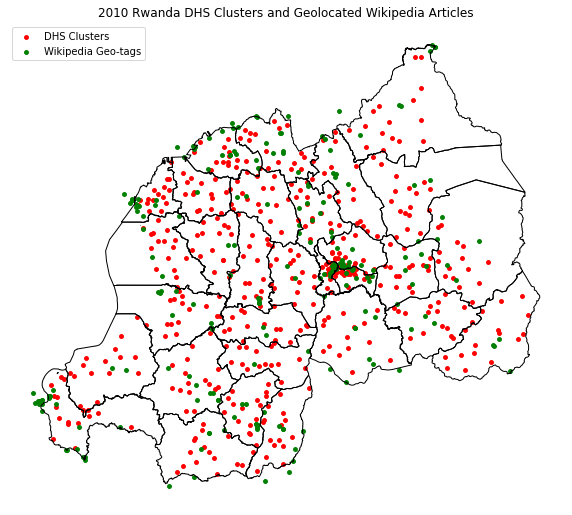

In [37]:
# Plot articles and clusters

rwanda_cluster_avg_asset_2010 = pd.read_csv('data/Rwanda/outputs/rwanda_cluster_avg_asset_2010.csv')
rwa_adm2 = gpd.read_file('data/Rwanda/gadm36_RWA_shp/gadm36_RWA_2.shp') # load Rwanda Adm 2 shapefile (source: GADM repo)

# plot
fig, ax = plt.subplots(figsize=(10, 10))
plot = rwa_adm2.plot(ax=ax, color='none', edgecolor='black',zorder=2) # plot Adm 2 shapefile
plot = ax.scatter(rwanda_cluster_avg_asset_2010['longitude'], 
                  rwanda_cluster_avg_asset_2010['latitude'],
                  c='red', s=15, label='DHS Clusters') # plot survey clusters
ax.scatter(article_df['longitude'], article_df['latitude'],
                  c='green', s=15, label='Wikipedia Geo-tags') # plot survey clusters
ax.spines['left'].set_visible(False) # hide all axes
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title('2010 Rwanda DHS Clusters and Geolocated Wikipedia Articles')
ax.legend()
plt.savefig('Rwanda_Wiki_Articles_and_2010_DHS_Clusts.png')
plt.show()

In [157]:
# ## plot cluster locations on a map of Rwanda -----

# from mpl_toolkits.axes_grid1 import make_axes_locatable # for color map

# rwanda_cluster_avg_asset_2010 = pd.read_csv('data/Rwanda/outputs/rwanda_cluster_avg_asset_2010.csv')
# rwa_adm2 = gpd.read_file('data/Rwanda/gadm36_RWA_shp/gadm36_RWA_2.shp') # load Rwanda Adm 2 shapefile (source: GADM repo)

# # plot
# fig, ax = plt.subplots(figsize=(10, 10))
# plot = rwa_adm2.plot(ax=ax, color='none', edgecolor='black',zorder=2) # plot Adm 2 shapefile
# plot = ax.scatter(rwanda_cluster_avg_asset_2010['longitude'], rwanda_cluster_avg_asset_2010['latitude'],
#                   c=rwanda_cluster_avg_asset_2010['cluster_wealth_mean'], cmap='RdBu', s=11) # plot survey clusters
# ax.scatter(article_df['longitude'], article_df['latitude'],
#                   c='green', s=11) # plot survey clusters
# ax.spines['left'].set_visible(False) # hide all axes
# ax.spines['bottom'].set_visible(False)
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)
# ax.get_xaxis().set_visible(False)
# ax.get_yaxis().set_visible(False)
# divider = make_axes_locatable(ax) # fix size of colormap to make it proportional to rest of graph
# cax = divider.append_axes("right", size="3%")
# cbar = fig.colorbar(plot, ax=ax, cax=cax)
# cbar.ax.set_ylabel('Avg cluster wealth', rotation=270)
# ax.set_title('2010 Rwanda DHS Clusters by Wealth and Geolocated Wikipedia Articles')
# plt.savefig('Rwanda_Wiki_Articles_and_2010_DHS_Clusts_Wealth.png')
# plt.show()

In [39]:
rwanda_cluster_avg_asset_2010

,cluster,latitude,longitude,cluster_wealth_mean
0,1.0,-2.532818,29.684726,-0.386620
1,2.0,-1.833858,30.310689,-0.421574
2,3.0,-1.888155,29.478298,-0.449724
3,4.0,-2.366763,30.521692,-0.390006
4,5.0,-2.171266,30.018541,-0.416924
...,...,...,...,...
487,488.0,-2.389778,29.451722,-0.490285
488,489.0,-2.144317,30.348895,-0.387647
489,490.0,-1.967830,30.441541,0.451675
490,491.0,-1.441294,30.063765,-0.217502


In [40]:
!ls

africa_poverty			models
articles			Papers
data				Proposal
DHS_Clusts_and_Wikipedia.ipynb	Rwanda_Wiki_Articles_and_2010_DHS_Clusts.png
ERNIE_Testing.ipynb		Untitled.ipynb
Figs				WikipediaPovertyMapping


In [42]:
dhs_clusts = pd.read_csv('data/dhs_clusters.csv')

In [43]:
dhs_clusts.head()

,country,year,lat,lon,wealthpooled,households,urban_rural
0,angola,2011,-12.350257,13.534922,2.595618,36,1
1,angola,2011,-12.360865,13.551494,2.209620,32,1
2,angola,2011,-12.613421,13.413085,0.906469,36,1
3,angola,2011,-12.581454,13.397711,1.105359,35,1
4,angola,2011,-12.578135,13.418748,1.879344,37,1


In [60]:
def process_country(country, year, country_abrev, dhs_df, plot=True):
    country_clusts = dhs_clusts[(dhs_clusts['country']== country) & (dhs_clusts['year']== year)]
    country_clusts = country_clusts.rename(columns={'lat':'latitude', 'lon' : 'longitude'})
    country_wiki_articles = {}
    for i in tqdm(range(len(country_clusts)), desc="Cluster Progress:"):
        country_wiki_articles.update(get_all_articles_near_clust(country_clusts.iloc[i], 
                                                         already_obtained=country_wiki_articles, 
                                                         keep_content=True, get_embeddings=True, 
                                                         model_funct= lambda x: get_article_embedding(x, tokenizer, model)))
    
    country_article_df = pd.DataFrame(country_wiki_articles).T
    country_article_df['embedding'] = country_article_df['embedding'].apply(lambda x : x.numpy())
    country_article_df = country_article_df.reset_index()
    country_article_df.rename(columns={'index': 'title'}, inplace=True)
    country_article_df.to_csv(f'{country}_Wiki.csv', index=False)

    if plot:
        # Plot articles and clusters
        adm2 = gpd.read_file(f'data/{country}/gadm36_{country_abrev}_shp/gadm36_{country_abrev}_2.shp') # load Rwanda Adm 2 shapefile (source: GADM repo)

        # plot
        fig, ax = plt.subplots(figsize=(10, 10))
        plot = adm2.plot(ax=ax, color='none', edgecolor='black',zorder=2) # plot Adm 2 shapefile
        plot = ax.scatter(country_clusts['longitude'], country_clusts['latitude'],
                          c='red', s=15, label='DHS Clusters') # plot survey clusters
        ax.scatter(country_article_df['longitude'], country_article_df['latitude'],
                          c='green', s=15, label='Wikipedia Geo-tags') # plot survey clusters
        ax.spines['left'].set_visible(False) # hide all axes
        ax.spines['bottom'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.set_title(f'{year} {country} DHS Clusters and Geolocated Wikipedia Articles')
        ax.legend()
        plt.savefig(f'{country}_Wiki_Articles_and_{year}_DHS_Clusts.png')
        plt.show()
    
    return country_article_df

In [70]:
type(gh_articles['embedding'].iloc[0])

numpy.ndarray

Cluster Progress::   0%|          | 0/422 [00:00<?, ?it/s]

Processing Nsawam
Processing Nsawam Adoagyire (municipal district)
Processing Adoagyiri
Processing Akuapim District
Processing Adeiso
Processing Upper West Akim (district)
Processing Pokrom


Cluster Progress::   0%|          | 1/422 [00:10<1:14:13, 10.58s/it]

Processing Afigya Kwabre South District
Processing Kodie, Ghana
Processing Afigya Kwabre District
Processing Abrepo
Processing Suame Municipal District
Processing Tafo
Processing Old Tafo Municipal District
Processing Wesley College of Education, Kumasi
Processing Kumasi City Mall
Processing Pankrono
Processing Adanwomase
Processing Ahwiaa
Processing Abrankese Stadium
Processing Prempeh College
Processing Kumasi High School
Processing Serwaa Nyarko Girls' Senior High School
Processing Kumasi Zoo
Processing Komfo Anokye Teaching Hospital
Processing Kejetia, Kumasi, Ghana
Processing Kumasi Nurses and Midwifery Training School
Processing Wesley Methodist Cathedral (Kumasi)
Processing St Peter's Cathedral Basilica, Kumasi
Processing Adum
Processing Kumasi Airport
Processing Afigya Sekyere District
Processing Sekyere South District
Processing Agona
Processing Ramseyer Memorial Presbyterian Church
Processing Asokore Mampong (municipal district)
Processing Asokore Mampong
Processing Anglican 

Cluster Progress::   0%|          | 2/422 [02:12<5:07:17, 43.90s/it]

Processing Buduburam
Processing Kasoa
Processing KAAF University College
Processing West Hills Mall
Processing University College of Management Studies


Cluster Progress::   1%|          | 3/422 [02:26<4:05:31, 35.16s/it]

Processing Bunkpurugu


Cluster Progress::   1%|          | 4/422 [02:28<2:53:58, 24.97s/it]

Processing Oduom
Processing Anwomaso
Processing Asokwa Municipal District
Processing Antoa
Processing Ejisu
Processing Kotei
Processing Kasei, Ghana
Processing Bantama


Cluster Progress::   1%|          | 5/422 [02:39<2:25:44, 20.97s/it]

Processing Mo River


Cluster Progress::   2%|▏         | 9/422 [02:41<1:41:40, 14.77s/it]

Processing Yamfo
Processing St. James Seminary Senior High School


Cluster Progress::   3%|▎         | 11/422 [02:48<1:18:01, 11.39s/it]

Processing Wamanafo


Cluster Progress::   3%|▎         | 12/422 [02:49<57:24,  8.40s/it]  

Processing Asamankese
Processing West Akim Municipal District


Cluster Progress::   4%|▎         | 15/422 [02:52<42:13,  6.22s/it]

Processing Sampa, Ghana
Processing Jaman North District


Cluster Progress::   4%|▍         | 16/422 [02:59<42:18,  6.25s/it]

Processing Hohoe
Processing Hohoe Municipal
Processing Godenu


Cluster Progress::   4%|▍         | 17/422 [03:05<41:56,  6.21s/it]

Processing Asante Akim South Municipal District
Processing Juaso
Processing Asankare
Processing Bompata
Processing Obogu


Cluster Progress::   4%|▍         | 18/422 [03:13<45:18,  6.73s/it]

Processing Gbeogo
Processing Zugu, Ghana


Cluster Progress::   5%|▍         | 19/422 [03:15<36:53,  5.49s/it]

Processing 1892 Sack of Salaga
Processing Salaga
Processing East Gonja Municipal District


Cluster Progress::   5%|▍         | 20/422 [03:21<36:56,  5.51s/it]

Processing Berekum-Jaman District
Processing Berekum
Processing Berekum East Municipal District
Processing Berekum Municipal District
Processing Biadan
Processing Berekum West District
Processing Jinijini
Processing Anyimon


Cluster Progress::   5%|▌         | 22/422 [03:32<36:48,  5.52s/it]

Processing Obrakyere


Cluster Progress::   6%|▌         | 24/422 [03:33<26:57,  4.06s/it]

Processing Ayensuano (district)
Processing Atimatim


Cluster Progress::   6%|▌         | 25/422 [03:36<24:21,  3.68s/it]

Processing Adenta East
Processing Oyarifa
Processing Mechanical Lloyd
Processing Adenta
Processing Ga East Municipal District
Processing West Africa Secondary School
Processing Ayi Mensa
Processing Pantang
Processing Abokobi
Processing Madina, Ghana
Processing Ashesi University
Processing Impact Hub Accra
Processing Berekuso
Processing Galaxy International School, Accra
Processing Asoprochona
Processing Mobile Web Ghana
Processing Action Senior High & Technical School
Processing Wisconsin International University College
Processing Presbyterian Boys' Senior High School


Cluster Progress::   6%|▋         | 27/422 [04:10<50:38,  7.69s/it]

Processing Konongo, Ghana
Processing Asante Akim Central Municipal District
Processing Patriensa


Cluster Progress::   7%|▋         | 28/422 [04:15<45:18,  6.90s/it]

Processing Nkoranza


Cluster Progress::   7%|▋         | 29/422 [04:17<34:54,  5.33s/it]

Processing Weta, Ghana
Processing Tadzewu


Cluster Progress::   7%|▋         | 31/422 [04:19<26:37,  4.09s/it]

Processing Labadi
Processing Iscom University Benin
Processing Zenith University College
Processing La General Hospital
Processing Labone Senior High School
Processing The Bank Hospital
Processing Open University of West Africa
Processing Korle-Klottey Municipal District
Processing Osu, Accra
Processing Ghana International School
Processing El Wak Stadium
Processing Cantonments, Accra
Processing High Commission of Nigeria, Accra
Processing Ghana Planetarium
Processing Ebenezer Presbyterian Church, Osu
Processing Osu Castle
Processing 37 Military Hospital
Processing Jubilee House
Processing Ako Adjei Interchange
Processing Royal Netherlands Embassy in Ghana
Processing Parliament of Ghana
Processing Kotoka International Airport
Processing Allied Air Flight 111
Processing Access Bank Ghana Plc
Processing Ghana-India Kofi Annan Centre of Excellence in ICT
Processing Consolidated Bank Ghana
Processing Liberation Day Monument
Processing Accra Ghana Temple
Processing La Tante DC10 Restaurant


Cluster Progress::   8%|▊         | 34/422 [11:14<4:46:38, 44.33s/it]

Processing Breman Asikuma
Processing Asikuma/Odoben/Brakwa District
Processing Central Region (Ghana)


Cluster Progress::   8%|▊         | 35/422 [11:19<3:29:23, 32.46s/it]

Processing Kwesimintsim, Ghana
Processing Takoradi European Public Cemetery
Processing Tanokrom, Takoradi
Processing Gyandu Park
Processing Sekondi-Takoradi
Processing Shama Ahanta East Metropolitan District
Processing Effia
Processing Takoradi Market Circle
Processing Takoradi Technical University
Processing Roman Catholic Diocese of Sekondi–Takoradi
Processing Bompeh Senior High Technical School
Processing Effiakuma
Processing New Takoradi
Processing Ghana Senior High Technical School (Takoradi)
Processing Bisa Abrewa Museum
Processing Fijai
Processing Takoradi Harbour
Processing Botumagyabu
Processing St. John's School, Sekondi
Processing Petronia City
Processing Ahantaman Girls Senior High School


Cluster Progress::   9%|▉         | 37/422 [12:00<3:05:36, 28.93s/it]

Processing Savelugu Municipal District
Processing Savelugu-Nanton Municipal District
Processing Savelugu
Processing Kogni


Cluster Progress::   9%|▉         | 38/422 [12:06<2:20:57, 22.02s/it]

Processing Tsito
Processing Tongor Kaira
Processing Peki (Krepi)
Processing Peki


Cluster Progress::   9%|▉         | 39/422 [12:17<2:00:09, 18.82s/it]

Processing Mankessim


Cluster Progress::   9%|▉         | 40/422 [12:20<1:28:14, 13.86s/it]

Processing Old Tafo
Processing Cocoa Research Institute of Ghana
Processing Bososo
Processing Bunso Arboretum


Cluster Progress::  10%|▉         | 41/422 [12:25<1:12:03, 11.35s/it]

Processing Jema
Processing Kintampo South District


Cluster Progress::  11%|█         | 45/422 [12:28<51:17,  8.16s/it]  

Processing Anlo Senior High School
Processing Cape St. Paul Lighthouse
Processing Woe, Ghana
Processing Anloga
Processing Tegbi
Processing Anloga District
Processing Dzelukope
Processing Alakple


Cluster Progress::  11%|█         | 46/422 [12:43<1:03:05, 10.07s/it]

Processing Assin South District
Processing Assin Kyekyewere


Cluster Progress::  11%|█         | 47/422 [12:45<49:00,  7.84s/it]  

Processing Krowor Municipal District
Processing Ledzokuku-Krowor Municipal District
Processing Nungua
Processing Sakumono


Cluster Progress::  11%|█▏        | 48/422 [12:55<52:53,  8.48s/it]

Processing Zambo, Ghana
Processing Lawra


Cluster Progress::  12%|█▏        | 49/422 [12:59<44:00,  7.08s/it]

Processing Upper Denkyira West District
Processing Diaso
Processing Bibiani/Anhwiaso/Bekwai Municipal District


Cluster Progress::  12%|█▏        | 51/422 [13:03<34:27,  5.57s/it]

Processing Sekondi-Takoradi Stadium
Processing Inchaban
Processing Takoradi Thermal Power Station


Cluster Progress::  12%|█▏        | 52/422 [13:08<33:18,  5.40s/it]

Processing Tagbo Falls
Processing Nkonya Ahenkro
Processing Kpeme


Cluster Progress::  13%|█▎        | 54/422 [13:12<27:08,  4.43s/it]

Processing Ajumako
Processing Mumford, Ghana
Processing Gomoa District
Processing Esakyir
Processing Ekumfi District
Processing Gomoa West District
Processing Apam
Processing Otuam


Cluster Progress::  13%|█▎        | 55/422 [13:27<45:29,  7.44s/it]

Processing Wa, Ghana
Processing Wa District
Processing Wa Municipal District
Processing Roman Catholic Diocese of Wa
Processing Wa Senior High Technical School
Processing Wa Technical University
Processing Charia, Ghana


Cluster Progress::  14%|█▎        | 57/422 [13:42<45:40,  7.51s/it]

Processing Juaben
Processing Juaben Municipal District
Processing Adanwomase Senior High School
Processing Sakora Wonoo
Processing Asonomaso
Processing Ejisu-Juaben Municipal District
Processing Ejisu Municipal District
Processing Ntonso
Processing Bobiri
Processing Effiduase
Processing Sekyere East District


Cluster Progress::  14%|█▍        | 59/422 [13:59<47:00,  7.77s/it]

Processing Jirapa/Lambussie District
Processing Jirapa, Ghana


Cluster Progress::  14%|█▍        | 60/422 [14:04<41:03,  6.81s/it]

Processing Bawku East District
Processing Bawku Municipal District
Processing Bawku
Processing Mogomnore


Cluster Progress::  15%|█▍        | 63/422 [14:11<32:40,  5.46s/it]

Processing Enchi
Processing Aowin/Suaman District


Cluster Progress::  15%|█▌        | 65/422 [14:15<26:26,  4.44s/it]

Processing Achiase District
Processing Achiase
Processing Aperadi
Processing Akim Swedru
Processing Birim South District
Processing Akim Oda
Processing Birim District
Processing Birim Central Municipal District


Cluster Progress::  16%|█▌        | 66/422 [14:30<44:52,  7.56s/it]

Processing Mamiri Forest Reserve


Cluster Progress::  16%|█▌        | 67/422 [14:32<35:17,  5.97s/it]

Processing Daka River


Cluster Progress::  16%|█▋        | 69/422 [14:33<25:49,  4.39s/it]

Processing Nkroful
Processing Essiama
Processing Ankobra River


Cluster Progress::  17%|█▋        | 71/422 [14:39<22:39,  3.87s/it]

Processing Nandom
Processing Lambussie


Cluster Progress::  17%|█▋        | 72/422 [14:44<24:36,  4.22s/it]

Processing Bimbilla


Cluster Progress::  18%|█▊        | 75/422 [14:46<18:14,  3.15s/it]

Processing Yendi Municipal District
Processing Yendi
Processing Roman Catholic Diocese of Yendi
Processing Meda, Togo


Cluster Progress::  18%|█▊        | 77/422 [14:52<18:24,  3.20s/it]

Processing Techimantia
Processing Duayaw Nkwanta
Processing Tano North Municipal District


Cluster Progress::  19%|█▊        | 79/422 [14:57<16:52,  2.95s/it]

Processing Ghana Communication Technology University
Processing Accra Academy
Processing Darkuman
Processing Bubuashie
Processing Ablekuma North Municipal District
Processing Mataheko
Processing Lapaz (Accra)
Processing Achimota
Processing Achimota Transport Terminal
Processing Abeka-Lapaz
Processing Okaikwei North Municipal District
Processing Accra Institute of Technology
Processing Methodist University College Ghana
Processing Hindu Monastery of Africa
Processing Odorkor
Processing Akweteyman
Processing Christian Village
Processing St Martin de Porres School
Processing Sakaman
Processing Kwashieman
Processing Alpha Beta Christian College
Processing Dansoman
Processing Ablekuma West Municipal District
Processing Dansoman Park
Processing Achimota Retail Centre
Processing Awoshie
Processing Mallam Interchange
Processing University of Ghana
Processing The Balme Library
Processing Dome, Ghana
Processing Gbegbe
Processing Haatso
Processing Ghana Institute of Languages


Cluster Progress::  19%|█▉        | 82/422 [16:17<57:07, 10.08s/it]

Processing Bongo District
Processing Bongo, Ghana


Cluster Progress::  20%|█▉        | 84/422 [16:21<43:15,  7.68s/it]

Processing Telania


Cluster Progress::  20%|██        | 86/422 [16:22<31:04,  5.55s/it]

Processing Taifa, Accra
Processing Reverend John Teye Memorial Institute
Processing University of Professional Studies
Processing Gbawe


Cluster Progress::  21%|██        | 87/422 [16:30<34:56,  6.26s/it]

Processing Weija Dam
Processing Weija


Cluster Progress::  21%|██        | 88/422 [16:33<28:30,  5.12s/it]

Processing Potrikrom


Cluster Progress::  21%|██        | 89/422 [16:34<21:55,  3.95s/it]

Processing Santeo
Processing Mfantsiman Girls' Secondary School
Processing Agona East District


Cluster Progress::  21%|██▏       | 90/422 [16:38<22:34,  4.08s/it]

Processing Wiamoase
Processing Asem, Kumasi


Cluster Progress::  22%|██▏       | 91/422 [16:42<21:57,  3.98s/it]

Processing Nkwatia Kwahu
Processing Abetifi
Processing Oboo, Ghana
Processing Abetifi Presbyterian College of Education
Processing Obomeng
Processing Bepong, Ghana
Processing Atibie, Ghana
Processing Kwahu District
Processing Mpraeso
Processing Kwahu Plateau
Processing Pepease
Processing Nkawkaw
Processing Kwahu West Municipal District


Cluster Progress::  22%|██▏       | 93/422 [17:03<32:12,  5.87s/it]

Processing Kwame Danso
Processing Sene District
Processing Sene West (district)


Cluster Progress::  23%|██▎       | 96/422 [17:07<24:35,  4.53s/it]

Processing Bunso, Ghana


Cluster Progress::  23%|██▎       | 97/422 [17:08<19:14,  3.55s/it]

Processing Dzolokpuita
Processing Vane, Avatime
Processing Amedzofe, Ghana
Processing Hlefi
Processing Kpedze


Cluster Progress::  24%|██▎       | 100/422 [17:17<17:53,  3.33s/it]

Processing Sunyani West District
Processing Odumase, Ghana
Processing Fiapre
Processing Notre Dame High School (Ghana)
Processing Coronation Park (Sunyani, Ghana)
Processing Sunyani Municipal District
Processing Abesim
Processing Sunyani
Processing Sunyani Technical University


Cluster Progress::  24%|██▍       | 101/422 [17:36<43:39,  8.16s/it]

Processing Pru East District
Processing Pru District
Processing Yeji


Cluster Progress::  24%|██▍       | 102/422 [17:41<38:11,  7.16s/it]

Processing Mepe
Processing Battor
Processing Aveyime-Battor
Processing Angongwi
Processing Adidome
Processing North Tongu District


Cluster Progress::  25%|██▍       | 104/422 [17:49<33:25,  6.31s/it]

Processing Nzema Solar Power Station


Cluster Progress::  25%|██▍       | 105/422 [17:52<26:47,  5.07s/it]

Processing Gbefi
Processing Kpando Municipal District
Processing Kpando


Cluster Progress::  25%|██▌       | 106/422 [17:57<26:28,  5.03s/it]

Processing Hamile
Processing Ouessa
Processing Ouessa Department


Cluster Progress::  26%|██▌       | 108/422 [18:00<21:22,  4.09s/it]

Processing Akuapim-Mampong
Processing Tetteh Quarshie Memorial Hospital
Processing Aburi Botanical Gardens
Processing Methodist Girls' High School (Mamfe)


Cluster Progress::  26%|██▌       | 110/422 [18:07<20:12,  3.89s/it]

Processing Sunon Asogli Thermal Power Station
Processing Armech Thermal Power Station
Processing Kpone Thermal Power Station II
Processing Adjei Kojo
Processing Volta Aluminum Company
Processing Tema Community 1
Processing Tema
Processing Kpone Thermal Power Station I
Processing Tema Community 5
Processing Tema Motorway Interchange
Processing Chemu Senior High School
Processing Ashaiman Senior High School
Processing Ghana Cement
Processing Prampram
Processing Tema West Municipal District
Processing Tema Metropolitan District
Processing Michel Camp
Processing Tema General Hospital
Processing Ningo Prampram District
Processing African Science Academy
Processing Tema Harbour
Processing Miotso
Processing Ashaiman
Processing Lashibi
Processing Sakumo Ramsar Site
Processing Sakumono Lagoon


Cluster Progress::  26%|██▋       | 111/422 [18:56<1:30:16, 17.42s/it]

Processing Kpong
Processing Nuaso
Processing Kpong Airfield
Processing Lower Manya Krobo Municipal District
Processing Agormanya
Processing Senchi
Processing Kpong Dam
Processing Somanya
Processing Yilo Krobo Municipal District
Processing Kaoga District
Processing Atimpoko


Cluster Progress::  27%|██▋       | 115/422 [19:16<1:09:57, 13.67s/it]

Processing Densu River


Cluster Progress::  27%|██▋       | 116/422 [19:18<52:09, 10.23s/it]  

Processing Akyem-Awenare
Processing Kwabeng
Processing Atiwa West District
Processing Atiwa District
Processing Abuakwa South Municipal District
Processing Bomaa
Processing Anyinam
Processing Atiwa East District
Processing Abuakwa North Municipal District


Cluster Progress::  28%|██▊       | 117/422 [19:34<1:01:03, 12.01s/it]

Processing Cape Coast Sports Stadium
Processing Cape Coast Metropolitan Assembly
Processing University Practice Secondary School
Processing Amissano
Processing Effutu
Processing Adisadel College
Processing University of Cape Coast Hospital
Processing Cape Coast Technical University
Processing University of Cape Coast
Processing St. Augustine's College (Cape Coast)
Processing Our Lady of Apostles (OLA) College of Education
Processing Mfantsipim School
Processing Fosu Lagoon
Processing Fort Victoria, Cape Coast
Processing Roman Catholic Archdiocese of Cape Coast
Processing Agona West Municipal District
Processing Cape Coast
Processing Cape Coast Castle
Processing Cape Coast Castle Museum
Processing St. Joseph's Minor Basilica Church
Processing Elmina Castle
Processing Elmina
Processing Komenda/Edina/Eguafo/Abirem Municipal District
Processing Aggrey Memorial A.M.E. Zion Senior High School


Cluster Progress::  28%|██▊       | 120/422 [20:52<1:21:35, 16.21s/it]

Processing Roman Catholic Diocese of Techiman
Processing Roman Catholic Diocese of Sunyani
Processing Techiman Municipal District
Processing Techiman
Processing Wenchi
Processing Wenchi Municipal District
Processing Tano River
Processing Techiman North District
Processing Tuobodom
Processing Aworowa
Processing Buoyem


Cluster Progress::  29%|██▉       | 124/422 [21:21<34:41,  6.98s/it]  

Processing Lebanon, Ashaiman


Cluster Progress::  30%|███       | 128/422 [21:25<10:52,  2.22s/it]

Processing Akatsi College of Education
Processing Roman Catholic Diocese of Keta–Akatsi
Processing Akatsi
Processing Akatsi District


Cluster Progress::  31%|███       | 131/422 [21:39<14:37,  3.02s/it]

Processing Wassa-Akropong
Processing Wassa Amenfi East Municipal District


Cluster Progress::  32%|███▏      | 134/422 [21:45<09:04,  1.89s/it]

Processing Ziou Department
Processing Zecco Department


Cluster Progress::  32%|███▏      | 135/422 [21:49<12:05,  2.53s/it]

Processing Pokuase Interchange
Processing Kwabenya


Cluster Progress::  33%|███▎      | 138/422 [21:54<08:23,  1.77s/it]

Processing Tarkwa
Processing Iduapriem Gold Mine
Processing TNA Park
Processing Wassa West District
Processing George Grant University of Mines and Technology
Processing Tarkwa Senior High School
Processing Tarkwa mine
Processing Aboso


Cluster Progress::  34%|███▎      | 142/422 [22:14<12:11,  2.61s/it]

Processing Obuasi Airport
Processing Jacobu
Processing Akrofuom District
Processing Akrokerri


Cluster Progress::  35%|███▍      | 146/422 [22:23<08:03,  1.75s/it]

Processing Tamale Stadium
Processing Tamale, Ghana
Processing Tamale Girls' Senior High School
Processing Anbariya Sunni Community
Processing Tamale Metropolitan District
Processing Tamale Technical University
Processing Sakasaka
Processing Roman Catholic Archdiocese of Tamale
Processing Zujung
Processing Tamale Teaching Hospital
Processing University for Development Studies
Processing Jisonaayili
Processing Kanvili
Processing Dungu, Ghana
Processing Taha, Ghana
Processing Yong, Ghana


Cluster Progress::  35%|███▌      | 149/422 [22:59<26:58,  5.93s/it]

Processing Awutu/Effutu/Senya District
Processing Effutu Municipal District
Processing Winneba
Processing Muni-Pomadze Ramsar Site
Processing Ayensu River
Processing Gomoa Mpota


Cluster Progress::  36%|███▌      | 150/422 [23:12<37:15,  8.22s/it]

Processing Tongo, Ghana
Processing Talensi-Nabdam District
Processing Tongo Hills
Processing Bolgatanga District
Processing Bolgatanga Municipal District
Processing Bolgatanga


Cluster Progress::  36%|███▌      | 152/422 [23:28<33:23,  7.42s/it]

Processing Lake Bosumtwi
Processing Asiwa
Processing Bosome Freho District


Cluster Progress::  36%|███▋      | 153/422 [23:41<40:20,  9.00s/it]

Processing Amasaman
Processing Pokuase, Ghana
Processing Ga West Municipal District
Processing Ashongman
Processing Kuntunse
Processing Ghana Satellite Earth Station


Cluster Progress::  37%|███▋      | 155/422 [24:00<37:35,  8.45s/it]

Processing Moree, Ghana
Processing Yamoransa


Cluster Progress::  37%|███▋      | 156/422 [24:06<33:50,  7.63s/it]

Processing Shai Hills
Processing Amanokrom
Processing Christ Presbyterian Church, Akropong
Processing Akrofi-Christaller Institute
Processing Akropong
Processing Akuapim North Municipal District
Processing Dawu (Ghana)
Processing Abiriw


Cluster Progress::  37%|███▋      | 157/422 [24:30<56:01, 12.68s/it]

Processing Roman Catholic Diocese of Obuasi
Processing Len Clay Stadium
Processing Obuasi Municipal District
Processing Obuasi East District
Processing Adansi West District
Processing Dominase
Processing Obuasi
Processing Obuasi Gold Mine
Processing Akrofuom


Cluster Progress::  37%|███▋      | 158/422 [24:49<1:04:14, 14.60s/it]

Processing Navrongo Airport
Processing Cathedral Basilica of Our Lady of Seven Sorrows
Processing Roman Catholic Diocese of Navrongo–Bolgatanga
Processing Kassena-Nankana Municipal District
Processing Navrongo
Processing Kassena-Nankana District
Processing Navrongo Solar Power Station
Processing Kassena-Nankana West District
Processing Pikworo Slave camp
Processing Paga Crocodile Pond


Cluster Progress::  38%|███▊      | 160/422 [25:24<1:03:03, 14.44s/it]

Processing Offinso North District
Processing Akumadan


Cluster Progress::  38%|███▊      | 162/422 [25:29<35:55,  8.29s/it]  

Processing Agona Senior High School


Cluster Progress::  39%|███▉      | 166/422 [25:32<10:27,  2.45s/it]

Processing Paga


Cluster Progress::  40%|████      | 169/422 [25:36<05:53,  1.40s/it]

Processing Suhum/Kraboa/Coaltar District
Processing Suhum Municipal District
Processing Asuboe


Cluster Progress::  40%|████      | 170/422 [25:42<12:31,  2.98s/it]

Processing Adafienu
Processing Hedzranawo
Processing Three Town Senior High School
Processing Denu
Processing Ketu Municipal District
Processing Tokor
Processing Nogokpo
Processing Diamond Cement Ghana Limited
Processing Klikor
Processing Agbozume


Cluster Progress::  41%|████      | 171/422 [26:03<34:34,  8.26s/it]

Processing Pampanso
Processing Pakro
Processing Dago, Ghana


Cluster Progress::  41%|████      | 173/422 [26:10<22:54,  5.52s/it]

Processing Volta Regional Museum
Processing Roman Catholic Diocese of Ho
Processing Ho Municipal
Processing Ho, Ghana
Processing OLA Girls Senior High School (Ho)
Processing Mawuko Girls Senior High School
Processing Mawuli School
Processing Ho Technical University
Processing Ho Teaching Hospital
Processing Klefe
Processing Akrofu


Cluster Progress::  41%|████      | 174/422 [26:33<44:56, 10.87s/it]

Processing Lungni
Processing Kpandai District
Processing Kpandai


Cluster Progress::  41%|████▏     | 175/422 [26:41<40:37,  9.87s/it]

Processing Barekese Senior High School
Processing Atwima Nwabiagya North District
Processing Barekese
Processing Barekese Dam


Cluster Progress::  42%|████▏     | 176/422 [26:48<38:01,  9.27s/it]

Processing Acherensua
Processing Ahafo mine
Processing Maaban
Processing Mabang
Processing Asutifi South (district)
Processing Hwidiem
Processing Kenyasi
Processing Asutifi District
Processing Asutifi North (district)


Cluster Progress::  42%|████▏     | 179/422 [27:06<23:54,  5.90s/it]

Processing Kwahu Afram Plains South (district)


Cluster Progress::  43%|████▎     | 180/422 [27:09<19:44,  4.89s/it]

Processing Bolgatanga Girls Senior High School
Processing Zuarungu Senior High School
Processing Bolgatanga East District
Processing Zuarungu


Cluster Progress::  43%|████▎     | 183/422 [27:17<12:01,  3.02s/it]

Processing Dormaa East District
Processing Wamfie


Cluster Progress::  44%|████▎     | 184/422 [27:22<13:50,  3.49s/it]

Processing Tono Dam


Cluster Progress::  44%|████▍     | 186/422 [27:25<09:43,  2.47s/it]

Processing Anomabu
Processing Fort Amsterdam, Ghana
Processing Abandze
Processing Saltpond
Processing Mfantsiman Municipal District


Cluster Progress::  45%|████▍     | 189/422 [27:45<14:48,  3.81s/it]

Processing Akosombo International School
Processing St. Barbara Catholic Church
Processing Akosombo Port
Processing Akosombo
Processing Akosombo Dam
Processing Akwamufie
Processing Adomi Bridge


Cluster Progress::  45%|████▌     | 190/422 [28:09<39:10, 10.13s/it]

Processing Tolon, Ghana
Processing Tolon-Kumbungu District
Processing Tolon District


Cluster Progress::  45%|████▌     | 191/422 [28:18<37:07,  9.64s/it]

Processing Bolgatanga Technical University


Cluster Progress::  45%|████▌     | 192/422 [28:21<29:13,  7.62s/it]

Processing Wiaga
Processing Sandema
Processing Builsa District
Processing Builsa North Municipal District


Cluster Progress::  46%|████▋     | 196/422 [28:33<12:33,  3.33s/it]

Processing Sumniboma


Cluster Progress::  47%|████▋     | 198/422 [28:37<09:23,  2.52s/it]

Processing Sikkim Manipal University, Ghana Learning Centre, Accra
Processing All Nations University
Processing New Juaben Municipal District
Processing New Juaben South Municipal Assembly
Processing Eastern Regional Hospital
Processing Roman Catholic Diocese of Koforidua
Processing New Juaben North Municipal Assembly
Processing Oyoko, Koforidua
Processing Koforidua Senior High Technical School
Processing Koforidua
Processing Koforidua Technical University


Cluster Progress::  48%|████▊     | 201/422 [29:10<21:23,  5.81s/it]

Processing Okere District


Cluster Progress::  48%|████▊     | 203/422 [29:14<13:16,  3.64s/it]

Processing Oda Senior High School


Cluster Progress::  48%|████▊     | 204/422 [29:16<11:57,  3.29s/it]

Processing Ankaful


Cluster Progress::  49%|████▊     | 205/422 [29:19<11:44,  3.24s/it]

Processing Japekrom
Processing New Drobo
Processing Jaman South Municipal District
Processing Jaman District


Cluster Progress::  49%|████▉     | 206/422 [29:32<21:31,  5.98s/it]

Processing Kade, Ghana
Processing Otumi
Processing Kwaebibirem Municipal District


Cluster Progress::  49%|████▉     | 207/422 [29:39<22:53,  6.39s/it]

Processing Kpale Kpalime
Processing Adaklu District
Processing Kpeve New Town
Processing Kpeve
Processing South Dayi District
Processing Bame, Ghana


Cluster Progress::  50%|████▉     | 209/422 [29:56<23:54,  6.74s/it]

Processing Gumani


Cluster Progress::  50%|█████     | 212/422 [29:59<09:45,  2.79s/it]

Processing Dambai
Processing Krachi East Municipal District


Cluster Progress::  50%|█████     | 213/422 [30:05<13:03,  3.75s/it]

Processing Anlo Afiadenyigba


Cluster Progress::  51%|█████     | 215/422 [30:08<09:06,  2.64s/it]

Processing Nadowli
Processing Nadowli District


Cluster Progress::  51%|█████     | 216/422 [30:13<11:15,  3.28s/it]

Processing Busunya
Processing Nkoranza North District
Processing Boabeng-Fiema Monkey Sanctuary


Cluster Progress::  51%|█████▏    | 217/422 [30:20<14:35,  4.27s/it]

Processing Bawku West District
Processing Zebilla
Processing Bingo, Boulgou


Cluster Progress::  53%|█████▎    | 222/422 [30:30<05:31,  1.66s/it]

Processing Abura/Asebu/Kwamankese District
Processing Upper Denkyira East Municipal District
Processing Dunkwa-on-Offin
Processing Upper Denkyira District
Processing Gyimi River


Cluster Progress::  53%|█████▎    | 223/422 [30:43<16:57,  5.11s/it]

Processing Binaba


Cluster Progress::  53%|█████▎    | 224/422 [30:45<14:14,  4.32s/it]

Processing Ada West District


Cluster Progress::  53%|█████▎    | 225/422 [30:47<11:56,  3.64s/it]

Processing Dadease
Processing Oyoko
Processing Asamang


Cluster Progress::  54%|█████▍    | 229/422 [30:55<05:49,  1.81s/it]

Processing Akuse


Cluster Progress::  55%|█████▍    | 231/422 [30:57<04:27,  1.40s/it]

Processing Youga
Processing Songo, Burkina Faso


Cluster Progress::  56%|█████▌    | 235/422 [31:04<03:30,  1.12s/it]

Processing Roman Catholic Diocese of Wiawso
Processing Wiawso
Processing Sefwi-Wiawso Municipal District
Processing Futa, Ghana


Cluster Progress::  56%|█████▌    | 236/422 [31:11<09:18,  3.00s/it]

Processing Fort San Sebastian
Processing Pra River (Ghana)


Cluster Progress::  56%|█████▌    | 237/422 [31:17<11:48,  3.83s/it]

Processing Nkoranza South Municipal District
Processing Nkoranza District


Cluster Progress::  58%|█████▊    | 243/422 [31:24<03:12,  1.07s/it]

Processing Asuogyaman District
Processing Atimpoku


Cluster Progress::  58%|█████▊    | 244/422 [31:29<06:15,  2.11s/it]

Processing Potsin


Cluster Progress::  59%|█████▊    | 247/422 [31:32<03:49,  1.31s/it]

Processing Denkyembour
Processing Akwatia
Processing St Roses Senior High (Akwatia)


Cluster Progress::  59%|█████▉    | 249/422 [31:41<07:43,  2.68s/it]

Processing Sewua
Processing Afari, Ghana


Cluster Progress::  60%|█████▉    | 252/422 [31:46<04:47,  1.69s/it]

Processing Afrancho


Cluster Progress::  62%|██████▏   | 261/422 [31:52<01:20,  2.00it/s]

Processing Abuakwa State College
Processing Apedwa
Processing Kibi, Ghana
Processing East Akim Municipal District


Cluster Progress::  62%|██████▏   | 262/422 [32:01<08:17,  3.11s/it]

Processing Fanteakwa North District
Processing Begoro
Processing Fanteakwa District


Cluster Progress::  63%|██████▎   | 265/422 [32:08<05:47,  2.21s/it]

Processing Wassa Amenfi West Municipal District
Processing Asankragua


Cluster Progress::  63%|██████▎   | 267/422 [32:13<05:19,  2.06s/it]

Processing Gbulahagu
Processing Golinga
Processing Foshegu


Cluster Progress::  64%|██████▎   | 268/422 [32:17<07:24,  2.88s/it]

Processing Sefwi Akontombra


Cluster Progress::  64%|██████▎   | 269/422 [32:20<06:53,  2.70s/it]

Processing Agona District
Processing Agona Swedru
Processing Afransi
Processing Gomoa Amoanda
Processing Gomoa Central District


Cluster Progress::  65%|██████▍   | 274/422 [32:32<03:49,  1.55s/it]

Processing Upper West Region


Cluster Progress::  66%|██████▋   | 280/422 [32:38<01:42,  1.38it/s]

Processing Asubima Forest Reserve


Cluster Progress::  67%|██████▋   | 283/422 [32:42<01:58,  1.17it/s]

Processing Apostolic Vicariate of Donkorkrom
Processing Afram Plains District
Processing Kwahu Afram Plains North (district)
Processing Donkorkrom
Processing Adiemmra


Cluster Progress::  68%|██████▊   | 286/422 [32:55<05:17,  2.34s/it]

Processing Half Assini Senior High School
Processing Half Assini


Cluster Progress::  68%|██████▊   | 287/422 [33:00<06:48,  3.03s/it]

Processing Prestea


Cluster Progress::  68%|██████▊   | 288/422 [33:03<06:58,  3.13s/it]

Processing Nzulezo


Cluster Progress::  68%|██████▊   | 289/422 [33:06<06:46,  3.06s/it]

Processing Fodoa


Cluster Progress::  69%|██████▊   | 290/422 [33:08<06:26,  2.92s/it]

Processing Nduom Sports Stadium


Cluster Progress::  69%|██████▉   | 293/422 [33:12<03:21,  1.56s/it]

Processing Gushegu Municipal District
Processing Gushegu
Processing Nawuni


Cluster Progress::  70%|██████▉   | 294/422 [33:18<06:30,  3.05s/it]

Processing Zabzugu-Tatale District
Processing Zabzugu


Cluster Progress::  71%|███████   | 300/422 [33:26<02:03,  1.01s/it]

Processing Ashanti Empire
Processing Gold Coast (region)
Processing Ajumako/Enyan/Essiam District


Cluster Progress::  72%|███████▏  | 302/422 [33:59<14:49,  7.41s/it]

Processing Twifo Praso
Processing Twifo/Heman/Lower Denkyira District


Cluster Progress::  72%|███████▏  | 304/422 [34:03<09:06,  4.63s/it]

Processing Zibogo


Cluster Progress::  73%|███████▎  | 309/422 [34:08<02:27,  1.31s/it]

Processing Naha, Ghana


Cluster Progress::  74%|███████▍  | 312/422 [34:11<01:43,  1.06it/s]

Processing Jasikan
Processing Jasikan District
Processing Roman Catholic Diocese of Jasikan
Processing Tapa Abotoase


Cluster Progress::  75%|███████▍  | 316/422 [34:20<02:23,  1.36s/it]

Processing Abrafo


Cluster Progress::  76%|███████▋  | 322/422 [34:26<01:09,  1.44it/s]

Processing West African Football Academy
Processing Attram De Visser Soccer Academy


Cluster Progress::  77%|███████▋  | 323/422 [34:31<03:16,  1.99s/it]

Processing Kintampo District
Processing Kintampo, Ghana
Processing Kintampo North Municipal District
Processing Kintampo Complex
Processing Kintampo waterfalls


Cluster Progress::  77%|███████▋  | 324/422 [34:47<10:01,  6.13s/it]

Processing North East Region, Ghana
Processing Nalerigu
Processing East Mamprusi Municipal Assembly
Processing Gambaga Witch camp
Processing Gambaga
Processing Gambaga Girls Senior High School


Cluster Progress::  79%|███████▉  | 333/422 [35:05<01:19,  1.12it/s]

Processing Frafraha
Processing Old Ningo


Cluster Progress::  79%|███████▉  | 335/422 [35:13<03:09,  2.18s/it]

Processing Keta Lagoon


Cluster Progress::  82%|████████▏ | 346/422 [35:26<00:40,  1.87it/s]

Processing Offinso
Processing Amowi
Processing Afigya Kwabre North District
Processing Offinso Municipal District


Cluster Progress::  82%|████████▏ | 347/422 [37:47<53:26, 42.76s/it]

Processing Dafor, Ghana
Processing Volta Region
Processing Ve Golokwati
Processing Ve-Koloenu


Cluster Progress::  83%|████████▎ | 349/422 [38:05<30:05, 24.73s/it]

Processing Garu, Ghana
Processing Garu District
Processing Garu-Tempane District


Cluster Progress::  84%|████████▎ | 353/422 [38:19<08:58,  7.81s/it]

Processing Bogoso


Cluster Progress::  84%|████████▍ | 354/422 [38:23<07:33,  6.66s/it]

Processing Walewale
Processing West Mamprusi Municipal Assembly


Cluster Progress::  86%|████████▋ | 364/422 [38:38<01:23,  1.44s/it]

Processing Adansi Asokwa District
Processing Adansi North District
Processing Fomena


Cluster Progress::  87%|████████▋ | 368/422 [38:54<01:56,  2.15s/it]

Processing Kengen, Ghana
Processing Beyin
Processing Atuabo


Cluster Progress::  88%|████████▊ | 372/422 [39:16<02:35,  3.12s/it]

Processing Fanteakwa South District
Processing Osino


Cluster Progress::  90%|████████▉ | 379/422 [39:38<00:57,  1.35s/it]

Processing Kwaso, Ghana
Processing Boankra Inland Port
Processing Boankra


Cluster Progress::  90%|█████████ | 380/422 [39:44<01:58,  2.82s/it]

Processing Amansie South District
Processing Manso Adubia
Processing Agroyesum
Processing Manso Nkwanta
Processing Amansie West District
Processing Asaman


Cluster Progress::  91%|█████████ | 382/422 [40:05<03:51,  5.78s/it]

Processing Senya Beraku


Cluster Progress::  91%|█████████▏| 386/422 [40:11<01:16,  2.14s/it]

Processing Sissala District
Processing Sissala East Municipal District
Processing Tumu, Ghana


Cluster Progress::  92%|█████████▏| 387/422 [40:17<02:00,  3.45s/it]

Processing Adum Banso


Cluster Progress::  92%|█████████▏| 390/422 [40:21<00:57,  1.79s/it]

Processing Kumawu
Processing Sekyere Kumawu (district)
Processing Bomfobiri Wildlife Sanctuary


Cluster Progress::  93%|█████████▎| 392/422 [40:30<01:27,  2.91s/it]

Processing Nsaba
Processing Awutu Breku
Processing Awutu Senya District


Cluster Progress::  93%|█████████▎| 393/422 [40:37<01:53,  3.91s/it]

Processing Kpetoe
Processing Agortime-Kpetoe


Cluster Progress::  95%|█████████▍| 400/422 [40:43<00:18,  1.21it/s]

Processing Satani
Processing Kumbungu


Cluster Progress::  95%|█████████▌| 402/422 [40:48<00:30,  1.52s/it]

Processing Agyina


Cluster Progress::  96%|█████████▌| 405/422 [40:53<00:22,  1.31s/it]

Processing Asuboni Rails


Cluster Progress::  96%|█████████▋| 407/422 [40:56<00:20,  1.35s/it]

Processing Lawra/Nandom District
Processing Lawra Municipal District


Cluster Progress::  97%|█████████▋| 408/422 [41:02<00:37,  2.70s/it]

Processing Kpilo
Processing Gumo
Processing Nyeshie


Cluster Progress::  97%|█████████▋| 409/422 [41:09<00:53,  4.14s/it]

Processing Wa West District
Processing Wechiau


Cluster Progress::  97%|█████████▋| 410/422 [41:15<00:54,  4.54s/it]

Processing Asunafo North Municipal District
Processing Goaso
Processing Asunafo District
Processing Roman Catholic Diocese of Goaso
Processing Santa, Ghana


Cluster Progress::  98%|█████████▊| 412/422 [41:29<00:53,  5.35s/it]

Processing Amanten


Cluster Progress::  98%|█████████▊| 413/422 [41:33<00:42,  4.74s/it]

Processing Aduman


Cluster Progress::  99%|█████████▊| 416/422 [41:37<00:14,  2.45s/it]

Processing Chato, Ghana


Cluster Progress:: 100%|██████████| 422/422 [41:43<00:00,  5.93s/it]


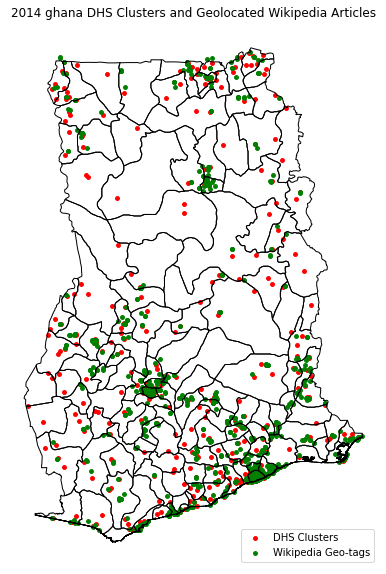

In [61]:
gh_articles = process_country('ghana', 2014, 'GHA', dhs_clusts, plot=True)

Cluster Progress::   0%|          | 0/208 [00:00<?, ?it/s]

Processing Opportunity Bank Uganda Limited
Processing Pride Microfinance Limited
Processing Kamwookya
Processing Institute of Certified Public Accountants of Uganda
Processing Bukoto
Processing Uganda Radio Network
Processing Women's Hospital International and Fertility Centre
Processing List of ambassadors of China to Uganda
Processing Uganda Law Society
Processing Hilton Garden Inn Kampala
Processing Kololo Senior Secondary School
Processing Uganda Specialized Nursing University
Processing FINCA Uganda Limited
Processing Uganda Wildlife Authority
Processing Kyebando
Processing Uganda Museum
Processing Uganda Cancer Institute
Processing Kadic Hospital
Processing Mulago
Processing Kitante Hill Secondary School
Processing Kampala Tower
Processing Mengo, Uganda
Processing Naguru, Uganda
Processing Kampala Hospital
Processing Upper Mulago Regional Referral Hospital
Processing Makerere University College of Health Sciences
Processing Makerere University School of Medicine
Processing Makere

Processing Mengo Hospital
Processing Finance Trust Bank
Processing Najjera
Processing Nsambya
Processing Nexus International University
Processing Bulange
Processing BRAC Uganda Bank Limited
Processing Team University
Processing Kabalagala
Processing Bugoloobi
Processing Uganda Joint Medical Store
Processing Mengo Crisis
Processing Institute of Petroleum Studies Kampala
Processing Katwe
Processing Paragon Hospital
Processing St. Lawrence University (Uganda)
Processing Kawempe Division
Processing Kampala International University
Processing Naalya
Processing Uro Care Hospital
Processing Kibuye, Uganda
Processing Galilee Community General Jewish Hospital of Uganda
Processing Lubaga Hospital
Processing Muyenga
Processing Lubaga
Processing Namungoona
Processing Roman Catholic Archdiocese of Kampala
Processing Rubaga Cathedral
Processing Katalemwa
Processing Hotel International 2000 Ltd
Processing Rubaga Division
Processing Lungujja
Processing Kansanga
Processing Ndeeba
Processing Nansana
Pr

Cluster Progress::   0%|          | 1/208 [14:46<50:59:20, 886.76s/it]

Processing Kireka
Processing Kabojja
Processing Kyengera


Cluster Progress::   1%|          | 2/208 [14:55<35:40:11, 623.36s/it]

Processing Kasangati
Processing Kyaliwajjala–Kira–Kasangati–Matugga Road
Processing Gayaza
Processing Bulindo
Processing Gayaza High School
Processing Kampala Outer Beltway
Processing Nsasa
Processing Kigulu, Uganda
Processing Kimwanyi
Processing Matugga


Cluster Progress::   2%|▏         | 5/208 [15:33<12:22:48, 219.55s/it]

Processing International Specialized Hospital of Uganda
Processing Ssabagabo


Cluster Progress::   3%|▎         | 6/208 [15:39<8:43:31, 155.50s/it] 

Processing Trinity College Nabbingo
Processing Nabbingo
Processing Roofings Group
Processing African Bible University (Uganda)
Processing King's College Budo
Processing Buddo hill


Cluster Progress::   3%|▎         | 7/208 [15:57<6:22:44, 114.25s/it]

Processing International School of Uganda
Processing Lubowa
Processing Kajjansi
Processing Kiruddu General Hospital
Processing Kajjansi Airfield
Processing Pangea Aviation Academy
Processing Nsangi
Processing Kampala–Entebbe Road
Processing Lweeza
Processing MAF Uganda


Cluster Progress::   4%|▍         | 9/208 [16:26<3:26:06, 62.14s/it] 

Processing St. Denis Ssebugwawo Secondary School
Processing Kampala University
Processing Ggaba
Processing Munyonyo
Processing Speke Resort and Conference Center
Processing Munyonyo Commonwealth Resort
Processing Bukasa Inland Port
Processing Bulingugwe Island
Processing Kigo, Uganda


Cluster Progress::   5%|▌         | 11/208 [17:10<2:12:23, 40.32s/it]

Processing Lake Victoria Serena Resort


Cluster Progress::   6%|▌         | 12/208 [17:18<1:40:25, 30.74s/it]

Processing Namugoga Solar Power Station


Cluster Progress::   6%|▋         | 13/208 [17:23<1:14:06, 22.80s/it]

Processing Namanve Thermal Power Station


Cluster Progress::   7%|▋         | 14/208 [17:27<55:25, 17.14s/it]  

Processing Sonde, Uganda


Cluster Progress::   7%|▋         | 15/208 [17:31<42:36, 13.25s/it]

Processing Kampala Industrial and Business Park
Processing Namanve
Processing Namilyango College
Processing Namilyango
Processing Seeta, Uganda


Cluster Progress::   8%|▊         | 17/208 [17:49<32:56, 10.35s/it]

Processing Semuto
Processing Matugga–Kapeeka Road


Cluster Progress::   9%|▊         | 18/208 [17:54<27:58,  8.83s/it]

Processing Buddu


Cluster Progress::   9%|▉         | 19/208 [17:57<22:17,  7.08s/it]

Processing Mpanga Central Forest Reserve
Processing Mpigi General Hospital
Processing Mpigi
Processing Mpigi District


Cluster Progress::  10%|▉         | 20/208 [18:09<26:10,  8.35s/it]

Processing Muduuma
Processing Uganda Deposit Protection Fund
Processing Habib Medical School


Cluster Progress::  11%|█         | 22/208 [18:18<18:57,  6.11s/it]

Processing Kassanda
Processing Myanzi–Kassanda–Bukuya–Kiboga Road
Processing Nkonge Solar Power Station
Processing Mityana–Bukuya–Kiboga Road


Cluster Progress::  11%|█         | 23/208 [18:30<24:15,  7.87s/it]

Processing Kalagi, Mukono
Processing Mukono District
Processing Nagalama
Processing Kitukutwe
Processing Naggalama Hospital
Processing Bukeerere
Processing Nakifuma


Cluster Progress::  12%|█▏        | 24/208 [18:51<35:58, 11.73s/it]

Processing Uganda Christian University
Processing Mukono Town
Processing Saints Andrew and Philip Cathedral, Mukono
Processing Mukono Health Centre IV
Processing Kyetume
Processing Mbalala


Cluster Progress::  12%|█▎        | 26/208 [19:10<29:45,  9.81s/it]

Processing Kasawo


Cluster Progress::  14%|█▍        | 29/208 [19:14<12:18,  4.13s/it]

Processing Kalisizo
Processing Kalisizo General Hospital


Cluster Progress::  15%|█▍        | 31/208 [19:21<10:08,  3.44s/it]

Processing Kayunga–Busaana–Nabuganyi Road
Processing Isimba Hydroelectric Power Station
Processing Ntenjeru
Processing Kayunga Hospital
Processing Kayunga
Processing Ntenjeru County


Cluster Progress::  15%|█▌        | 32/208 [19:36<20:03,  6.84s/it]

Processing Lutembe Bay
Processing Mahathi Fuel Transport and Storage Depot
Processing CoRSU Rehabilitation Hospital
Processing Kisubi Hospital
Processing St. Mary's College Kisubi
Processing Kisubi
Processing University of Kisubi
Processing Zika Forest
Processing Akright City
Processing Moriah Aviation Training Centre
Processing Nkumba University
Processing Nkumba
Processing Garuga, Uganda
Processing Abayita Ababiri


Cluster Progress::  16%|█▌        | 33/208 [20:16<49:34, 17.00s/it]

Processing Africa Renewal University
Processing Buganda
Processing Sentema
Processing Bunamwaya Stadium
Processing Wakiso Town
Processing Wakiso District
Processing Maya, Uganda
Processing Kampala–Mpigi Expressway


Cluster Progress::  18%|█▊        | 38/208 [20:50<15:38,  5.52s/it]  

Processing Butebi, Uganda
Processing Lake Wamala


Cluster Progress::  19%|█▉        | 39/208 [20:55<15:22,  5.46s/it]

Processing Roman Catholic Diocese of Kiyinda–Mityana
Processing Roman Catholic Diocese of Kasana–Luweero
Processing Mityana
Processing Mityana Hospital
Processing St Andrew's Cathedral, Namukozi
Processing Mityana District


Cluster Progress::  19%|█▉        | 40/208 [21:12<24:23,  8.71s/it]

Processing Mityana–Sekanyonyi–Busunju Road
Processing Sekanyonyi


Cluster Progress::  20%|█▉        | 41/208 [21:19<22:53,  8.22s/it]

Processing Namutumba District
Processing St. Charles Lwanga Buikwe Hospital
Processing Buikwe
Processing Buikwe District
Processing Bujagali Energy Limited


Cluster Progress::  21%|██        | 43/208 [21:35<20:54,  7.61s/it]

Processing Namutumba, Uganda
Processing Kitamilo
Processing Buvuma District


Cluster Progress::  21%|██        | 44/208 [21:44<21:44,  7.96s/it]

Processing Kabulasoke Solar Power Station
Processing Kabulasoke


Cluster Progress::  22%|██▏       | 45/208 [21:51<20:45,  7.64s/it]

Processing Kalungu District
Processing Kalungu, Uganda


Cluster Progress::  23%|██▎       | 47/208 [21:57<13:20,  4.97s/it]

Processing Kiboga District


Cluster Progress::  23%|██▎       | 48/208 [22:00<11:58,  4.49s/it]

Processing Lwengo District
Processing Mbiriizi
Processing Lwensinga
Processing Lwengo


Cluster Progress::  24%|██▍       | 50/208 [22:11<11:47,  4.48s/it]

Processing Bugweri District
Processing Bugiri General Hospital


Cluster Progress::  25%|██▍       | 51/208 [22:16<12:25,  4.75s/it]

Processing Busia, Uganda
Processing Busia, Kenya
Processing Lwei
Processing Busia Airport
Processing Masafu General Hospital
Processing Mbweka
Processing Busia County


Cluster Progress::  25%|██▌       | 52/208 [22:34<22:07,  8.51s/it]

Processing Jinja–Iganga–Bugiri–Tororo Road


Cluster Progress::  26%|██▌       | 54/208 [22:36<12:23,  4.83s/it]

Processing Nile International Hospital
Processing Roman Catholic Diocese of Jinja
Processing National Defence College, Uganda
Processing Bugembe
Processing Uganda Junior Staff College
Processing Jinja Hospital
Processing Uganda Hotel and Tourism Training Institute
Processing Nsaka University
Processing Jinja, Uganda
Processing Uganda Senior Command and Staff College
Processing Ripon Falls
Processing Wairaka
Processing Jinja Airport
Processing Kimaka
Processing Eastern Region, Uganda
Processing Source of the Nile Bridge
Processing Nyanza Textile Industries Limited
Processing Kiira Hydroelectric Power Station
Processing Nalubaale Hydroelectric Power Station
Processing Owen Falls
Processing Eskom Uganda Limited
Processing Buwenda
Processing Busoga College
Processing Jinja District
Processing Kakira Airport
Processing Kakira
Processing Kakira Thermal Power Station
Processing Kakira Sugar Works
Processing Njeru


Cluster Progress::  26%|██▋       | 55/208 [23:57<1:10:29, 27.65s/it]

Processing Bujagali Falls
Processing Bujagali Hydroelectric Power Station


Cluster Progress::  27%|██▋       | 56/208 [24:03<53:25, 21.09s/it]  

Processing Kamuli Sugar Limited
Processing Kamuli Mission Hospital
Processing Kamuli
Processing Kamuli District


Cluster Progress::  28%|██▊       | 58/208 [24:15<32:00, 12.80s/it]

Processing Kapchorwa
Processing Kapchorwa District
Processing Kapchorwa General Hospital
Processing Muyembe–Nakapiripirit Road
Processing Kyegegwa
Processing Kween District
Processing Binyiny


Cluster Progress::  28%|██▊       | 59/208 [24:36<38:25, 15.48s/it]

Processing Katakwi
Processing Katakwi General Hospital


Cluster Progress::  30%|██▉       | 62/208 [24:43<15:19,  6.29s/it]

Processing Nabumali High School
Processing Nabumali
Processing Bumbobi–Bubulo–Lwakhakha Road
Processing Bubulo
Processing Manafwa
Processing Kwangamor


Cluster Progress::  30%|███       | 63/208 [24:58<21:45,  9.00s/it]

Processing Islamic University in Uganda
Processing Tororo–Mbale–Soroti Road
Processing Nakaloke
Processing Busitema University Faculty of Health Sciences
Processing Mbale
Processing Bukedi District
Processing Mbale Hospital
Processing Mbale Regional Cancer Centre
Processing CURE Children's Hospital of Uganda
Processing LivingStone International University
Processing Kamonkoli


Cluster Progress::  32%|███▏      | 67/208 [25:34<14:16,  6.07s/it]

Processing Tororo–Opuyo–Lira High Voltage Power Line
Processing Opuyo–Moroto High Voltage Power Line
Processing Soroti Solar Power Station


Cluster Progress::  33%|███▎      | 69/208 [25:43<11:08,  4.81s/it]

Processing Soroti
Processing Soroti University School of Medicine and Health Sciences
Processing Soroti Hospital
Processing Roman Catholic Diocese of Soroti
Processing Soroti District
Processing East African Civil Aviation Academy
Processing Soroti Airport
Processing Terrewode Women's Community Hospital
Processing Soroti University
Processing Teso College Aloet
Processing Arapai
Processing Soroti Fruit Processing Factory


Cluster Progress::  34%|███▎      | 70/208 [26:31<41:01, 17.84s/it]

Processing Osukuru Thermal Power Station
Processing Osukuru Industrial Complex
Processing Tororo Wind Power Station
Processing Tororo Cement Limited
Processing Tororo Girls School
Processing Tororo Thermal Power Station
Processing Tororo Airport
Processing Tororo Solar Power Station
Processing Tororo Rock
Processing Tororo
Processing Tororo General Hospital
Processing Tororo Inland Port
Processing Bujagali–Tororo–Lessos High Voltage Power Line
Processing St. Peter's College Tororo
Processing Malaba, Uganda


Cluster Progress::  34%|███▍      | 71/208 [27:15<58:40, 25.70s/it]

Processing Roman Catholic Archdiocese of Tororo
Processing Simba Cement Uganda Limited


Cluster Progress::  35%|███▍      | 72/208 [27:20<44:02, 19.43s/it]

Processing Mifumi
Processing Nagongera
Processing Mwenge
Processing Busolwe General Hospital
Processing Busolwe


Cluster Progress::  35%|███▌      | 73/208 [27:34<40:13, 17.88s/it]

Processing Kaberamaido District
Processing Kaberamaido
Processing Dokolo District
Processing Dokolo
Processing Soroti–Dokolo–Lira Road


Cluster Progress::  36%|███▌      | 75/208 [27:50<27:04, 12.21s/it]

Processing Mayuge Solar Power Station
Processing Buluba Hospital
Processing Mayuge
Processing Mayuge Thermal Power Station
Processing Mayuge Sugar Industries Limited
Processing Fairland University


Cluster Progress::  37%|███▋      | 77/208 [28:08<21:30,  9.85s/it]

Processing Budadiri
Processing Buhugu
Processing Mutufu
Processing Bulambuli
Processing Mbale–Bulambuli–Siti Medium Voltage Power Line
Processing Bugisu sub-region


Cluster Progress::  38%|███▊      | 80/208 [28:23<12:07,  5.68s/it]

Processing Katine


Cluster Progress::  39%|███▉      | 81/208 [28:25<09:42,  4.58s/it]

Processing Butaleja District
Processing Butaleja
Processing Budaka District
Processing Kadama
Processing Budaka, Uganda


Cluster Progress::  39%|███▉      | 82/208 [28:41<16:48,  8.00s/it]

Processing Manafwa District
Processing Bududa District
Processing Bududa General Hospital
Processing Bududa


Cluster Progress::  40%|████      | 84/208 [28:53<13:06,  6.34s/it]

Processing Bulambuli District


Cluster Progress::  41%|████      | 85/208 [28:55<10:31,  5.14s/it]

Processing Bukwo General Hospital
Processing Bukwo
Processing Bukwo District
Processing Suam, Uganda
Processing Suam, Kenya


Cluster Progress::  41%|████▏     | 86/208 [29:10<16:17,  8.02s/it]

Processing Kapchorwa–Suam Road
Processing Siti II Hydroelectric Power Station


Cluster Progress::  43%|████▎     | 89/208 [29:16<07:35,  3.83s/it]

Processing Mbale District
Processing Namisindwa District


Cluster Progress::  44%|████▍     | 91/208 [29:25<07:23,  3.79s/it]

Processing Pallisa District
Processing Tirinyi
Processing Iganga–Tirinyi–Kamonkoli–Mbale Road


Cluster Progress::  44%|████▍     | 92/208 [29:34<10:07,  5.23s/it]

Processing Muyembe


Cluster Progress::  45%|████▍     | 93/208 [29:37<08:50,  4.61s/it]

Processing Sironko District


Cluster Progress::  47%|████▋     | 97/208 [29:42<03:17,  1.78s/it]

Processing Kibuku
Processing Kibuku District


Cluster Progress::  48%|████▊     | 99/208 [29:49<04:08,  2.28s/it]

Processing Luuka Town
Processing Luuka District


Cluster Progress::  50%|████▉     | 103/208 [29:56<02:33,  1.46s/it]

Processing Serere
Processing Serere District


Cluster Progress::  50%|█████     | 104/208 [30:02<04:34,  2.64s/it]

Processing Olua I Refugee settlement


Cluster Progress::  51%|█████     | 106/208 [30:05<03:24,  2.01s/it]

Processing Apac
Processing Apac District


Cluster Progress::  52%|█████▏    | 108/208 [30:12<04:04,  2.45s/it]

Processing Arua
Processing Arua Airport
Processing Arua Regional Referral Hospital
Processing Arua Regional Cancer Centre
Processing Mvara Secondary School
Processing Roman Catholic Diocese of Arua
Processing St. Joseph's College, Ombaci
Processing Muni University
Processing Ombaci
Processing Nile University of Uganda
Processing Kuluva Hospital


Cluster Progress::  53%|█████▎    | 110/208 [30:41<12:06,  7.41s/it]

Processing Rhino Camp Refugee Settlement


Cluster Progress::  54%|█████▍    | 113/208 [30:47<05:27,  3.45s/it]

Processing Acholibur–Gulu–Olwiyo Road


Cluster Progress::  55%|█████▍    | 114/208 [30:49<04:56,  3.15s/it]

Processing St. Joseph's College Layibi
Processing Roman Catholic Archdiocese of Gulu
Processing Gulu Regional Cancer Centre
Processing Gulu Hospital
Processing Lira–Gulu–Nebbi–Arua High Voltage Power Line
Processing Acholi Inn
Processing Gulu
Processing Northern Region, Uganda
Processing Gulu University School of Medicine
Processing Gulu Military Hospital
Processing Gulu University
Processing St. Joseph's Cathedral, Gulu
Processing St. Mary's Hospital Lacor
Processing Gulu Airport
Processing Pope John Paul II College, Gulu
Processing Sir Samuel Baker Secondary School
Processing Ocer Campion Jesuit College
Processing Alokolum


Cluster Progress::  56%|█████▌    | 116/208 [31:36<17:28, 11.40s/it]

Processing St. Joseph's Hospital Kitgum
Processing Kitgum Hospital
Processing Kitgum, Uganda


Cluster Progress::  57%|█████▋    | 119/208 [31:46<08:06,  5.47s/it]

Processing Roman Catholic Diocese of Kotido
Processing Kotido
Processing Kotido Airport


Cluster Progress::  59%|█████▊    | 122/208 [31:55<04:43,  3.30s/it]

Processing Lira
Processing All Saints University
Processing Lira, Uganda
Processing Roman Catholic Diocese of Lira
Processing Lira Hospital
Processing Lango College
Processing Lira Airport
Processing Lira University
Processing Kamtech Logistics Uganda Limited


Cluster Progress::  59%|█████▉    | 123/208 [32:18<13:02,  9.20s/it]

Processing Moroto Airport
Processing Moroto Ateker Cement Company Limited
Processing Roman Catholic Diocese of Moroto


Cluster Progress::  60%|█████▉    | 124/208 [32:26<12:23,  8.85s/it]

Processing Moroto District
Processing Moroto Hospital
Processing Moroto Town


Cluster Progress::  60%|██████    | 125/208 [32:34<11:48,  8.54s/it]

Processing Palorinya Refugee Settlement
Processing Obongi District


Cluster Progress::  61%|██████    | 126/208 [32:40<10:34,  7.74s/it]

Processing Achwa River


Cluster Progress::  61%|██████    | 127/208 [32:41<08:02,  5.95s/it]

Processing Nebbi District
Processing Nebbi Airport


Cluster Progress::  62%|██████▏   | 128/208 [32:47<07:59,  6.00s/it]

Processing Mount Kadam


Cluster Progress::  62%|██████▏   | 129/208 [32:51<06:43,  5.11s/it]

Processing Nabilatuk District


Cluster Progress::  63%|██████▎   | 131/208 [32:53<03:55,  3.05s/it]

Processing Lodonga
Processing Basilica of the Blessed Virgin Mary, Lodonga


Cluster Progress::  63%|██████▎   | 132/208 [32:58<04:38,  3.66s/it]

Processing Agbinika Power Station
Processing Yumbe General Hospital
Processing Yumbe
Processing Yumbe District


Cluster Progress::  64%|██████▍   | 134/208 [33:09<05:04,  4.12s/it]

Processing Amolatar
Processing Amolatar District


Cluster Progress::  65%|██████▌   | 136/208 [33:15<04:01,  3.35s/it]

Processing University of the Sacred Heart Gulu


Cluster Progress::  67%|██████▋   | 139/208 [33:19<02:09,  1.87s/it]

Processing Kaabong District
Processing Kaabong
Processing Kaabong General Hospital
Processing Kotido District
Processing Kalapata sub-county


Cluster Progress::  67%|██████▋   | 140/208 [33:34<06:32,  5.78s/it]

Processing Lolelia sub-county


Cluster Progress::  68%|██████▊   | 142/208 [33:38<04:02,  3.67s/it]

Processing Kathile sub-county


Cluster Progress::  70%|███████   | 146/208 [33:42<01:35,  1.54s/it]

Processing St. Joseph’s Hospital Maracha


Cluster Progress::  72%|███████▏  | 150/208 [33:48<01:08,  1.18s/it]

Processing Minakulu


Cluster Progress::  73%|███████▎  | 151/208 [33:52<01:44,  1.83s/it]

Processing Adilang


Cluster Progress::  73%|███████▎  | 152/208 [33:55<02:13,  2.38s/it]

Processing Agago


Cluster Progress::  74%|███████▎  | 153/208 [33:59<02:30,  2.73s/it]

Processing Lira District


Cluster Progress::  74%|███████▍  | 154/208 [34:04<02:58,  3.30s/it]

Processing Aloi


Cluster Progress::  75%|███████▌  | 156/208 [34:08<02:10,  2.50s/it]

Processing Kole District
Processing Kole, Uganda


Cluster Progress::  76%|███████▋  | 159/208 [34:16<01:50,  2.25s/it]

Processing Napak


Cluster Progress::  77%|███████▋  | 160/208 [34:20<02:09,  2.69s/it]

Processing Lorengecora
Processing Rwekunye–Apac–Aduku–Lira–Kitgum–Musingo Road


Cluster Progress::  77%|███████▋  | 161/208 [34:29<03:29,  4.46s/it]

Processing Matany Airstrip
Processing Matany Hospital


Cluster Progress::  78%|███████▊  | 162/208 [34:34<03:43,  4.85s/it]

Processing Koch-Goma


Cluster Progress::  78%|███████▊  | 163/208 [34:41<04:00,  5.35s/it]

Processing Otuke District
Processing Otuke


Cluster Progress::  79%|███████▉  | 165/208 [34:49<03:06,  4.34s/it]

Processing Nyagak III Hydroelectric Power Station
Processing Paidha
Processing Nyagak Hydroelectric Power Station
Processing Nyapea
Processing St. Aloysius College Nyapea
Processing Holy Family Hospital Nyapea
Processing Goli, Uganda
Processing Nyagak II Hydroelectric Power Station


Cluster Progress::  80%|███████▉  | 166/208 [35:20<08:40, 12.39s/it]

Processing Bundibugyo Airport
Processing Bundibugyo General Hospital
Processing Fort Portal–Bundibugyo–Lamia Road
Processing Bundibugyo
Processing Bundibugyo District
Processing Sindila Hydroelectric Power Station
Processing Ndugutu Hydroelectric Power Station


Cluster Progress::  80%|████████  | 167/208 [35:44<10:57, 16.04s/it]

Processing Ishaka Adventist Hospital
Processing Ishaka
Processing Kampala International University School of Health Sciences
Processing Kashenyi–Mitooma Road


Cluster Progress::  81%|████████  | 168/208 [36:02<10:53, 16.34s/it]

Processing Kigorobya


Cluster Progress::  81%|████████▏ | 169/208 [36:06<08:14, 12.67s/it]

Processing Kikuube
Processing Hoima District


Cluster Progress::  82%|████████▏ | 170/208 [36:14<07:07, 11.25s/it]

Processing Roman Catholic Diocese of Hoima
Processing Hoima
Processing Bwendero Sugar Factory
Processing Hoima Hospital
Processing Hoima–Kinyara–Kafu High Voltage Power Line
Processing Mparo, Hoima


Cluster Progress::  82%|████████▏ | 171/208 [36:34<08:39, 14.03s/it]

Processing Katuna–Muko Road
Processing Rwanda Cancer Centre
Processing Butaro Hospital


Cluster Progress::  83%|████████▎ | 172/208 [36:43<07:24, 12.35s/it]

Processing Rukiga District


Cluster Progress::  83%|████████▎ | 173/208 [36:47<05:46,  9.89s/it]

Processing Mparo, Rukiga


Cluster Progress::  84%|████████▎ | 174/208 [36:51<04:34,  8.08s/it]

Processing Rubona, Bunyangabu


Cluster Progress::  84%|████████▍ | 175/208 [36:54<03:42,  6.75s/it]

Processing Virika Hospital
Processing Roman Catholic Diocese of Fort Portal
Processing Kasusu
Processing Kyebambe Girls' Secondary School
Processing Fort Portal
Processing Uganda Pentecostal University
Processing Fins Medical University
Processing Fort Portal Hospital
Processing St. Leo's College, Kyegobe
Processing Mountains of the Moon University
Processing Nyakasura School
Processing Kabarole District
Processing Fort Portal Airport


Cluster Progress::  85%|████████▍ | 176/208 [37:39<09:38, 18.07s/it]

Processing Lubilia Hydroelectric Power Station
Processing Nkenda–Mpondwe–Beni High Voltage Power Line
Processing Mpondwe
Processing Mbarara–Kisangani Road
Processing Bwera General Hospital
Processing Kasindi


Cluster Progress::  86%|████████▌ | 178/208 [37:59<06:34, 13.16s/it]

Processing Kagando Hospital


Cluster Progress::  86%|████████▌ | 179/208 [38:04<05:09, 10.67s/it]

Processing Rwimi Hydroelectric Power Station
Processing Rwimi
Processing Hima, Uganda
Processing Hima Cement Limited
Processing Mubuku I Hydroelectric Power Station


Cluster Progress::  87%|████████▋ | 181/208 [38:19<03:47,  8.41s/it]

Processing Kagadi District
Processing African Rural University
Processing Kagadi
Processing Kyenjojo–Kabwoya Road
Processing Kagadi General Hospital


Cluster Progress::  88%|████████▊ | 183/208 [38:32<02:52,  6.90s/it]

Processing Bunagana, Uganda
Processing Bunagana, Democratic Republic of the Congo
Processing Mgahinga Gorilla National Park
Processing Kisoro District
Processing Kisoro
Processing Mount Gahinga
Processing Mount Muhabura
Processing Kabale–Kisoro–Bunagana Road
Processing Mount Sabyinyo
Processing Lake Mutanda


Cluster Progress::  89%|████████▉ | 185/208 [38:54<03:07,  8.17s/it]

Processing Kakyeka Stadium
Processing Ntare School
Processing Mbarara Regional Cancer Centre
Processing Mbarara
Processing NSSF Mbarara Complex
Processing Mbarara University School of Medicine
Processing Mbarara Hospital
Processing GBK Dairy Products Limited
Processing Holy Innocents Children's Hospital
Processing Mayanja Memorial Hospital
Processing Roman Catholic Archdiocese of Mbarara
Processing Maryhill High School
Processing Mbarara High School
Processing Ruharo Mission Hospital
Processing Mbarara Northern Bypass Road
Processing Bishop Stuart University
Processing Makenke
Processing Rwampara district
Processing Mbarara district
Processing Pearl Dairies Honey Factory
Processing Western Region, Uganda
Processing Mbarara Airport


Cluster Progress::  89%|████████▉ | 186/208 [40:01<09:23, 25.60s/it]

Processing Mbarara–Ishaka Road
Processing Kibingo, Uganda
Processing Sheema
Processing Mbarara University


Cluster Progress::  91%|█████████ | 189/208 [40:14<03:24, 10.75s/it]

Processing Kisiizi Hospital
Processing Kisizi
Processing Kisiizi Hydroelectric Power Station


Cluster Progress::  92%|█████████▏| 191/208 [40:24<02:08,  7.57s/it]

Processing Kamwenge District
Processing Kamwenge


Cluster Progress::  92%|█████████▏| 192/208 [40:32<02:02,  7.64s/it]

Processing Rwamwanja Refugee Settlement


Cluster Progress::  93%|█████████▎| 193/208 [40:36<01:38,  6.59s/it]

Processing Kambuga General Hospital
Processing Great Lakes Regional University
Processing Nengo Bridge Hydroelectric Power Station
Processing Kanungu


Cluster Progress::  93%|█████████▎| 194/208 [40:48<01:52,  8.00s/it]

Processing Kanungu District


Cluster Progress::  94%|█████████▍| 196/208 [40:53<00:59,  4.98s/it]

Processing Biso, Uganda
Processing Hoima–Butiaba–Wanseko Road
Processing Waki Hydroelectric Power Station


Cluster Progress::  95%|█████████▍| 197/208 [41:01<01:05,  5.99s/it]

Processing Uganda Martyrs’ Hospital Ibanda
Processing Ibanda
Processing Ibanda University
Processing Ibanda District
Processing Kabujogera


Cluster Progress::  95%|█████████▌| 198/208 [41:17<01:30,  9.01s/it]

Processing Bihanga


Cluster Progress::  98%|█████████▊| 203/208 [41:22<00:10,  2.07s/it]

Processing Mitooma
Processing Mitooma District


Cluster Progress::  99%|█████████▊| 205/208 [41:30<00:08,  2.69s/it]

Processing Kikorongo–Ishaka Road
Processing Rubirizi
Processing Rubirizi District
Processing Kyambura Hydroelectric Power Station


Cluster Progress::  99%|█████████▉| 206/208 [41:41<00:10,  5.12s/it]

Processing Ankole Western University
Processing Sheema District


Cluster Progress:: 100%|██████████| 208/208 [41:46<00:00, 12.05s/it]


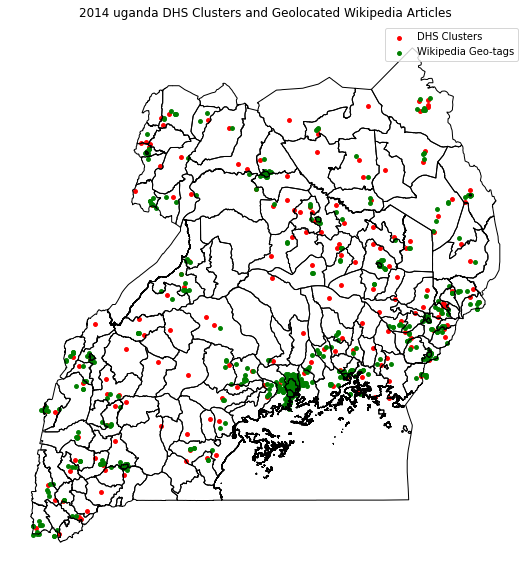

In [62]:
ug_articles = process_country('uganda', 2014, 'UGA', dhs_clusts, plot=True)

In [63]:
ng_articles = process_country('nigeria', 2010, 'NGA', dhs_clusts, plot=True)

Cluster Progress::   0%|          | 0/239 [00:00<?, ?it/s]

Processing Igumale


Cluster Progress::   0%|          | 1/239 [00:02<08:12,  2.07s/it]

Processing A344 highway (Nigeria)


Cluster Progress::   3%|▎         | 7/239 [00:06<02:39,  1.45it/s]

Processing Old Bridge, Makurdi
Processing Benue State University
Processing Otukpa
Processing Makurdi
Processing Aper Aku Stadium
Processing Agbadi


Cluster Progress::   3%|▎         | 8/239 [00:20<17:59,  4.68s/it]

Processing Madalla
Processing Zuma Rock


Cluster Progress::   4%|▍         | 10/239 [00:24<12:16,  3.22s/it]

Processing Jabi Lake
Processing Crushed Rock, Mpape
Processing Embassy of Indonesia, Abuja
Processing June 2014 Kaduna and Abuja attacks
Processing Anglican Diocese of Abuja
Processing Abuja
Processing World Trade Centre Abuja
Processing Nigerian Export-Import Bank
Processing Moshood Abiola National Stadium
Processing National Hospital, Abuja
Processing Millennium Tower (Abuja)


Cluster Progress::   5%|▍         | 11/239 [01:07<56:55, 14.98s/it]

Processing Dekina


Cluster Progress::   5%|▌         | 13/239 [01:10<30:22,  8.06s/it]

Processing Okenyi


Cluster Progress::   6%|▌         | 14/239 [01:12<23:50,  6.36s/it]

Processing Anglican Diocese of Okene
Processing Okene
Processing Ogaminan


Cluster Progress::   6%|▋         | 15/239 [01:19<24:09,  6.47s/it]

Processing Anglican Diocese of Lokoja
Processing Lokoja
Processing Mount Patti
Processing World War Cenotaph, Lokoja
Processing Confluence Stadium


Cluster Progress::   7%|▋         | 16/239 [01:34<34:11,  9.20s/it]

Processing Ogori/Magongo


Cluster Progress::   7%|▋         | 17/239 [01:37<27:01,  7.30s/it]

Processing Geregu nuclear power plant
Processing Ajaokuta
Processing Kogi State


Cluster Progress::   9%|▉         | 21/239 [01:49<11:09,  3.07s/it]

Processing Kwara Stadium
Processing Ilorin
Processing Ilorin Emirate
Processing Al-Hikmah University
Processing Ilorin International Airport
Processing A123 highway (Nigeria)


Cluster Progress::   9%|▉         | 22/239 [02:06<27:02,  7.48s/it]

Processing Omu-Aran
Processing Iloffa


Cluster Progress::  10%|█         | 24/239 [02:16<20:38,  5.76s/it]

Processing New Nyanya
Processing Nasarawa State


Cluster Progress::  11%|█         | 26/239 [02:22<14:19,  4.03s/it]

Processing Wamba, Nigeria


Cluster Progress::  11%|█▏        | 27/239 [02:25<12:51,  3.64s/it]

Processing Kainji Lake


Cluster Progress::  14%|█▍        | 33/239 [02:29<03:06,  1.10it/s]

Processing Federal University of Technology, Minna
Processing Chanchaga
Processing Minna
Processing Minna Township Stadium
Processing Federal Government College Minna


Cluster Progress::  15%|█▍        | 35/239 [02:42<10:44,  3.16s/it]

Processing Riyom


Cluster Progress::  15%|█▌        | 36/239 [02:45<10:06,  2.99s/it]

Processing Rwang Pam Stadium
Processing ECWA Evangel Hospital
Processing 2010 Jos riots
Processing University of Jos
Processing Jos
Processing Jos North
Processing Air Force Military School, Jos


Cluster Progress::  17%|█▋        | 41/239 [03:08<07:47,  2.36s/it]

Processing A345 highway (Nigeria)


Cluster Progress::  18%|█▊        | 42/239 [03:11<08:09,  2.48s/it]

Processing Madagali


Cluster Progress::  18%|█▊        | 43/239 [03:14<08:46,  2.69s/it]

Processing Adamawa State University
Processing 2014 Mubi bombing
Processing Mubi
Processing Mararaba Mubi
Processing Mubi North


Cluster Progress::  19%|█▉        | 45/239 [03:27<12:59,  4.02s/it]

Processing Michika


Cluster Progress::  19%|█▉        | 46/239 [03:31<13:29,  4.19s/it]

Processing Adamawa Emirate
Processing Yola, Adamawa
Processing Yola Airport
Processing Ahmadu Ribadu College
Processing Jimeta
Processing American University of Nigeria


Cluster Progress::  21%|██        | 49/239 [03:51<13:47,  4.36s/it]

Processing Azare Airstrip


Cluster Progress::  21%|██        | 50/239 [03:53<11:42,  3.72s/it]

Processing Azare


Cluster Progress::  22%|██▏       | 52/239 [03:59<09:40,  3.10s/it]

Processing Disina
Processing Foggo


Cluster Progress::  24%|██▍       | 57/239 [04:05<03:23,  1.12s/it]

Processing Chibok schoolgirls kidnapping
Processing Chibok


Cluster Progress::  27%|██▋       | 64/239 [04:25<03:11,  1.09s/it]

Processing March 2015 Maiduguri suicide bombing
Processing Maiduguri
Processing El-Kanemi Stadium


Cluster Progress::  28%|██▊       | 68/239 [04:36<04:28,  1.57s/it]

Processing Akko, Nigeria
Processing Kumo, Gombe, Nigeria


Cluster Progress::  29%|██▉       | 69/239 [04:41<07:34,  2.67s/it]

Processing Pantami Stadium
Processing Gombe, Gombe
Processing Gombe State
Processing Abubakar Umar Memorial Stadium
Processing Hildi


Cluster Progress::  30%|██▉       | 71/239 [04:53<10:40,  3.81s/it]

Processing Ibi, Nigeria


Cluster Progress::  31%|███       | 74/239 [04:57<05:25,  1.97s/it]

Processing Federal Government College Wukari
Processing Wukari Federation
Processing Wukari


Cluster Progress::  33%|███▎      | 79/239 [05:08<03:37,  1.36s/it]

Processing Nguru, Nigeria
Processing Nguru Airstrip


Cluster Progress::  33%|███▎      | 80/239 [05:13<06:23,  2.41s/it]

Processing Birnin Kudu


Cluster Progress::  38%|███▊      | 90/239 [05:20<01:13,  2.04it/s]

Processing Ranchers Bees Stadium
Processing Lugard Footbridge
Processing Northern Region, Nigeria
Processing Kaduna
Processing Sultan Bello Mosque
Processing Abubakar Mahmud Gumi Market
Processing Arewa House
Processing Badarawa, Kaduna
Processing Ahmadu Bello Stadium


Cluster Progress::  38%|███▊      | 91/239 [05:46<20:24,  8.28s/it]

Processing Zaria
Processing 2015 Zaria massacre
Processing Ahmadu Bello University
Processing Zaria Quds Day massacres
Processing Zaki Biam Massacre
Processing Wusasa
Processing Barewa College
Processing Federal College of Education, Zaria
Processing Sabon Gari, Kaduna
Processing Nigerian College of Aviation Technology


Cluster Progress::  38%|███▊      | 92/239 [06:29<45:18, 18.50s/it]

Processing Bebeji
Processing Garun Mallam
Processing Madobi


Cluster Progress::  39%|███▉      | 93/239 [06:38<38:04, 15.65s/it]

Processing Warawa


Cluster Progress::  39%|███▉      | 94/239 [06:42<29:41, 12.29s/it]

Processing Garko, Nigeria
Processing Sumaila


Cluster Progress::  40%|████      | 96/239 [06:50<18:20,  7.70s/it]

Processing Kura, Nigeria


Cluster Progress::  41%|████      | 97/239 [06:52<14:31,  6.14s/it]

Processing Tofa, Nigeria
Processing Rimin Gado


Cluster Progress::  41%|████      | 98/239 [07:00<15:14,  6.49s/it]

Processing Dawakin Tofa


Cluster Progress::  41%|████▏     | 99/239 [07:04<13:25,  5.76s/it]

Processing Wudil
Processing Kano State University of Technology


Cluster Progress::  42%|████▏     | 100/239 [07:09<13:17,  5.74s/it]

Processing 2014 Kano attack
Processing Great Mosque of Kano
Processing Kano
Processing Kurmi Market
Processing Kano Emirate Council
Processing 2013 Kano bus bombing
Processing Gidan Rumfa
Processing Gidan Makama Museum Kano
Processing Sani Abacha Stadium
Processing Fagge
Processing Rumfa College, Kano
Processing EAS Airlines Flight 4226
Processing Our Lady of Fatima Cathedral, Kano
Processing Gwale
Processing Pillars Stadium
Processing Dala, Kano
Processing Bayero University Kano
Processing Ancient Kano City Walls
Processing 1956 Kano Airport BOAC Argonaut crash
Processing Nasarawa, Kano State
Processing Kano Municipal
Processing Kano air disaster
Processing Tarauni


Cluster Progress::  43%|████▎     | 102/239 [08:29<44:27, 19.47s/it]  

Processing Mani, Nigeria


Cluster Progress::  44%|████▍     | 106/239 [08:34<12:05,  5.45s/it]

Processing Dandume


Cluster Progress::  45%|████▍     | 107/239 [08:38<10:41,  4.86s/it]

Processing Baure, Nigeria


Cluster Progress::  47%|████▋     | 112/239 [08:44<03:17,  1.55s/it]

Processing Dange Shuni


Cluster Progress::  47%|████▋     | 113/239 [08:47<04:19,  2.06s/it]

Processing Illela, Nigeria
Processing A1 highway (Nigeria)
Processing Birni-N'Konni Department
Processing Birni-N'Konni


Cluster Progress::  48%|████▊     | 115/239 [09:00<07:43,  3.74s/it]

Processing Yabo, Nigeria
Processing Shagari, Nigeria


Cluster Progress::  49%|████▊     | 116/239 [09:08<10:10,  4.96s/it]

Processing Sokoto Caliphate
Processing Sokoto North
Processing Sokoto
Processing Sokoto Sultanate Council
Processing Sokoto State
Processing Sokoto South


Cluster Progress::  49%|████▉     | 118/239 [09:44<20:27, 10.14s/it]

Processing Kaura Namoda


Cluster Progress::  50%|█████     | 120/239 [09:48<11:41,  5.90s/it]

Processing Ozara, Abia State
Processing Alayi
Processing Amaozara


Cluster Progress::  51%|█████     | 121/239 [09:59<14:33,  7.40s/it]

Processing A3 highway (Nigeria)
Processing Aba North
Processing Anglican Diocese of Aba Ngwa North
Processing Trinity Theological College, Umuahia
Processing Anglican Diocese of Isiala-Ngwa South
Processing Anglican Diocese of Isiala Ngwa


Cluster Progress::  51%|█████     | 122/239 [10:15<19:13,  9.86s/it]

Processing Enyimba International Stadium
Processing Aba, Abia
Processing Abia State Polytechnic
Processing Christ the King Cathedral, Aba
Processing Mgboko
Processing Aba Nigeria Temple
Processing Obi Ngwa
Processing Aba South
Processing Osisioma Ngwa


Cluster Progress::  51%|█████▏    | 123/239 [10:57<37:52, 19.59s/it]

Processing Ukwa West


Cluster Progress::  53%|█████▎    | 126/239 [11:02<14:14,  7.56s/it]

Processing Umuahia North
Processing Anglican Diocese of Umuahia
Processing Umuahia
Processing Isuikwuato
Processing Anglican Diocese of Isuikwuato
Processing Umuahia Township Stadium
Processing Umuekwule
Processing Umukabia


Cluster Progress::  53%|█████▎    | 127/239 [11:29<25:11, 13.49s/it]

Processing Oraukwu, Anambra
Processing Awka-Etiti
Processing Alor, Anambra
Processing Archaeology of Igbo-Ukwu
Processing Igbo-Ukwu
Processing Ameki Formation
Processing Agulu


Cluster Progress::  54%|█████▎    | 128/239 [12:03<36:16, 19.61s/it]

Processing Awgbu
Processing Ihiala
Processing Ozubulu
Processing Azia (town)


Cluster Progress::  54%|█████▍    | 129/239 [12:17<32:40, 17.83s/it]

Processing Kingdom of Nri
Processing Enugwu Ukwu
Processing Nawfia
Processing Awka South
Processing Nibo
Processing Umuawulu
Processing Oko Town


Cluster Progress::  55%|█████▍    | 131/239 [12:50<28:18, 15.72s/it]

Processing Eziowelle
Processing Otolo
Processing Nnewi


Cluster Progress::  55%|█████▌    | 132/239 [13:11<30:46, 17.25s/it]

Processing Gabros Stadium


Cluster Progress::  56%|█████▌    | 133/239 [13:14<23:08, 13.10s/it]

Processing Oba, Anambra


Cluster Progress::  56%|█████▌    | 134/239 [13:17<17:43, 10.13s/it]

Processing Intafact Beverages Limited
Processing Onitsha
Processing Second Niger bridge
Processing Okpoko
Processing Nkpor
Processing Anglican Diocese of Asaba
Processing Asaba, Delta
Processing Obosi
Processing Kwale, Nigeria
Processing Asaba-Ase


Cluster Progress::  56%|█████▋    | 135/239 [13:48<28:24, 16.39s/it]

Processing Ogbunike
Processing Ogbunike Caves
Processing Ogidi, Anambra
Processing Ifitedunu, Dunukofia


Cluster Progress::  57%|█████▋    | 137/239 [14:07<20:24, 12.01s/it]

Processing Adadama


Cluster Progress::  58%|█████▊    | 138/239 [14:10<15:42,  9.33s/it]

Processing Ishiagu
Processing Aninri


Cluster Progress::  58%|█████▊    | 139/239 [14:17<14:31,  8.72s/it]

Processing Afikpo South


Cluster Progress::  59%|█████▉    | 142/239 [14:23<06:27,  3.99s/it]

Processing Ngwo Pine forest
Processing Abia, Nigeria
Processing Abor, Enugu


Cluster Progress::  60%|█████▉    | 143/239 [14:30<07:38,  4.78s/it]

Processing Igbo Eze North
Processing Igbo Eze South
Processing Unadu


Cluster Progress::  60%|██████    | 144/239 [14:40<10:14,  6.47s/it]

Processing Nkanu West
Processing Renaissance University
Processing Agbani


Cluster Progress::  61%|██████    | 145/239 [14:49<11:07,  7.10s/it]

Processing Anglican Diocese of Udi
Processing Udi, Enugu


Cluster Progress::  61%|██████    | 146/239 [14:55<10:34,  6.83s/it]

Processing Nnamdi Azikiwe Stadium
Processing Biafra
Processing Enugu
Processing Anglican Diocese of Enugu
Processing Enugu North
Processing Anglican Diocese of Enugu North
Processing Enugu South
Processing Enugu State
Processing Ekulu River
Processing Akanu Ibiam International Airport


Cluster Progress::  62%|██████▏   | 149/239 [15:52<16:13, 10.81s/it]

Processing University of Nigeria
Processing Ezema Nru
Processing Nsukka
Processing Ede-Oballa
Processing Nru Nsukka
Processing Anglican Diocese of Nsukka


Cluster Progress::  63%|██████▎   | 150/239 [16:22<24:26, 16.48s/it]

Processing Ekwereazu
Processing Amaimo
Processing Ahiara
Processing Aboh Mbaise


Cluster Progress::  63%|██████▎   | 151/239 [16:36<23:04, 15.73s/it]

Processing Itu, Imo State


Cluster Progress::  64%|██████▍   | 153/239 [16:39<12:00,  8.38s/it]

Processing Abajah
Processing Jesus de Greatest
Processing Isu, Nigeria
Processing Uburu Ekwe
Processing Amandugba
Processing Umundugba
Processing Ngugu
Processing Nkwerre


Cluster Progress::  64%|██████▍   | 154/239 [17:02<18:06, 12.79s/it]

Processing Mbieri
Processing Umunoha
Processing Obazu


Cluster Progress::  66%|██████▌   | 157/239 [17:14<08:34,  6.27s/it]

Processing Orlu, Imo


Cluster Progress::  66%|██████▌   | 158/239 [17:19<08:14,  6.11s/it]

Processing Dikenafai


Cluster Progress::  67%|██████▋   | 159/239 [17:23<07:20,  5.51s/it]

Processing Ubomiri
Processing Irete
Processing Government Secondary School, Owerri
Processing Imo State
Processing Owerri
Processing Obodoukwu
Processing Dan Anyiam Stadium
Processing Orji


Cluster Progress::  67%|██████▋   | 160/239 [17:50<15:33, 11.82s/it]

Processing Abak
Processing Akwa Ibom State
Processing University of Uyo Teaching Hospital


Cluster Progress::  67%|██████▋   | 161/239 [18:05<16:41, 12.84s/it]

Processing Akwa Ibom State Polytechnic
Processing Essien Udim


Cluster Progress::  68%|██████▊   | 162/239 [18:10<13:12, 10.30s/it]

Processing Nsit-Ibom


Cluster Progress::  68%|██████▊   | 163/239 [18:12<10:02,  7.93s/it]

Processing Opobo–Nkoro


Cluster Progress::  69%|██████▉   | 166/239 [18:16<04:13,  3.47s/it]

Processing Ikot Okoro
Processing Etinan


Cluster Progress::  70%|██████▉   | 167/239 [18:23<05:32,  4.61s/it]

Processing Oron people
Processing Uyo High School
Processing Uyo
Processing Uyo Township Stadium
Processing Godswill Akpabio International Stadium
Processing A342 highway (Nigeria)


Cluster Progress::  70%|███████   | 168/239 [18:43<10:50,  9.17s/it]

Processing Akassa


Cluster Progress::  71%|███████   | 169/239 [18:45<08:19,  7.14s/it]

Processing Ogbia


Cluster Progress::  71%|███████   | 170/239 [18:49<06:52,  5.98s/it]

Processing Yenagoa Township Stadium


Cluster Progress::  72%|███████▏  | 171/239 [18:50<05:22,  4.74s/it]

Processing Yenagoa


Cluster Progress::  72%|███████▏  | 173/239 [18:54<03:24,  3.09s/it]

Processing Mbe Mountains Community Forest


Cluster Progress::  73%|███████▎  | 174/239 [18:56<03:06,  2.88s/it]

Processing Ababene


Cluster Progress::  73%|███████▎  | 175/239 [18:58<02:51,  2.68s/it]

Processing Ekori


Cluster Progress::  74%|███████▎  | 176/239 [19:02<03:03,  2.91s/it]

Processing Duke Town
Processing Calabar
Processing Roman Catholic Archdiocese of Calabar
Processing Federal Government Girls College, Calabar
Processing University of Calabar


Cluster Progress::  74%|███████▎  | 176/239 [19:41<07:02,  6.71s/it]


ConnectionError: HTTPConnectionPool(host='en.wikipedia.org', port=80): Max retries exceeded with url: /w/api.php?prop=info%7Cpageprops&inprop=url&ppprop=disambiguation&redirects=&titles=Calabar+River&format=json&action=query (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f388f55f910>: Failed to establish a new connection: [Errno -3] Temporary failure in name resolution'))

Automatic pdb calling has been turned ON


In [ ]:
mw_articles = process_country('malawi', 2014, 'MWI', dhs_clusts, plot=True) 

In [ ]:
tz_articles = process_country('tanzania', 2010, 'TZA', dhs_clusts, plot=True)  

### Ghana

In [44]:
ghana_clusts = dhs_clusts[(dhs_clusts['country']== 'ghana') & (dhs_clusts['year']== 2014)]

In [45]:
ghana_clusts = ghana_clusts.rename(columns={'lat':'latitude', 'lon' : 'longitude'})

In [46]:
gh_wiki_articles = {}
for i in tqdm(range(len(ghana_clusts)), desc="Cluster Progress:"):
    gh_wiki_articles.update(get_all_articles_near_clust(ghana_clusts.iloc[i], 
                                                     already_obtained=gh_wiki_articles, 
                                                     keep_content=True, get_embeddings=True, 
                                                     model_funct= lambda x: get_article_embedding(x, tokenizer, model)))

Cluster Progress::   0%|          | 0/422 [00:00<?, ?it/s]

Processing Nsawam
Processing Nsawam Adoagyire (municipal district)
Processing Adoagyiri
Processing Akuapim District
Processing Adeiso
Processing Upper West Akim (district)
Processing Pokrom


Cluster Progress::   0%|          | 1/422 [00:17<2:01:22, 17.30s/it]

Processing Afigya Kwabre South District
Processing Kodie, Ghana
Processing Afigya Kwabre District
Processing Abrepo
Processing Suame Municipal District
Processing Tafo
Processing Old Tafo Municipal District
Processing Wesley College of Education, Kumasi
Processing Kumasi City Mall
Processing Pankrono
Processing Adanwomase
Processing Ahwiaa
Processing Abrankese Stadium
Processing Prempeh College
Processing Kumasi High School
Processing Serwaa Nyarko Girls' Senior High School
Processing Kumasi Zoo
Processing Komfo Anokye Teaching Hospital
Processing Kejetia, Kumasi, Ghana
Processing Kumasi Nurses and Midwifery Training School
Processing Wesley Methodist Cathedral (Kumasi)
Processing St Peter's Cathedral Basilica, Kumasi
Processing Adum
Processing Kumasi Airport
Processing Afigya Sekyere District
Processing Sekyere South District
Processing Agona
Processing Ramseyer Memorial Presbyterian Church
Processing Asokore Mampong (municipal district)
Processing Asokore Mampong
Processing Anglican 

Cluster Progress::   0%|          | 2/422 [02:38<6:20:19, 54.33s/it]

Processing Buduburam
Processing Kasoa
Processing KAAF University College
Processing West Hills Mall
Processing University College of Management Studies


Cluster Progress::   1%|          | 3/422 [03:02<5:16:58, 45.39s/it]

Processing Bunkpurugu


Cluster Progress::   1%|          | 4/422 [03:06<3:49:10, 32.90s/it]

Processing Oduom
Processing Anwomaso
Processing Asokwa Municipal District
Processing Antoa
Processing Ejisu
Processing Kotei
Processing Kasei, Ghana
Processing Bantama


Cluster Progress::   2%|▏         | 8/422 [03:31<1:13:32, 10.66s/it]

Processing Mo River


Cluster Progress::   2%|▏         | 10/422 [03:34<41:08,  5.99s/it] 

Processing Yamfo
Processing St. James Seminary Senior High School


Cluster Progress::   3%|▎         | 11/422 [03:43<48:04,  7.02s/it]

Processing Wamanafo


Cluster Progress::   3%|▎         | 14/422 [03:48<21:59,  3.23s/it]

Processing Asamankese
Processing West Akim Municipal District


Cluster Progress::   4%|▎         | 15/422 [03:55<28:26,  4.19s/it]

Processing Sampa, Ghana
Processing Jaman North District


Cluster Progress::   4%|▍         | 16/422 [04:04<39:08,  5.78s/it]

Processing Hohoe
Processing Hohoe Municipal
Processing Godenu


Cluster Progress::   4%|▍         | 17/422 [04:14<48:06,  7.13s/it]

Processing Asante Akim South Municipal District
Processing Juaso
Processing Asankare
Processing Bompata
Processing Obogu


Cluster Progress::   4%|▍         | 18/422 [04:26<58:05,  8.63s/it]

Processing Gbeogo
Processing Zugu, Ghana


Cluster Progress::   5%|▍         | 19/422 [04:31<49:55,  7.43s/it]

Processing 1892 Sack of Salaga
Processing Salaga
Processing East Gonja Municipal District


Cluster Progress::   5%|▍         | 21/422 [04:41<39:09,  5.86s/it]

Processing Berekum-Jaman District
Processing Berekum
Processing Berekum East Municipal District
Processing Berekum Municipal District
Processing Biadan
Processing Berekum West District
Processing Jinijini
Processing Anyimon


Cluster Progress::   5%|▌         | 23/422 [05:03<49:40,  7.47s/it]  

Processing Obrakyere


Cluster Progress::   6%|▌         | 24/422 [05:06<40:48,  6.15s/it]

Processing Ayensuano (district)
Processing Atimatim


Cluster Progress::   6%|▌         | 26/422 [05:12<28:10,  4.27s/it]

Processing Adenta East
Processing Oyarifa
Processing Mechanical Lloyd
Processing Adenta
Processing Ga East Municipal District
Processing West Africa Secondary School
Processing Ayi Mensa
Processing Pantang
Processing Abokobi
Processing Madina, Ghana
Processing Ashesi University
Processing Impact Hub Accra
Processing Berekuso
Processing Galaxy International School, Accra
Processing Asoprochona
Processing Mobile Web Ghana
Processing Action Senior High & Technical School
Processing Wisconsin International University College
Processing Presbyterian Boys' Senior High School


Cluster Progress::   6%|▋         | 27/422 [06:07<2:08:11, 19.47s/it]

Processing Konongo, Ghana
Processing Asante Akim Central Municipal District
Processing Patriensa


Cluster Progress::   7%|▋         | 28/422 [06:16<1:47:07, 16.31s/it]

Processing Nkoranza


Cluster Progress::   7%|▋         | 30/422 [06:19<56:58,  8.72s/it]  

Processing Weta, Ghana
Processing Tadzewu


Cluster Progress::   8%|▊         | 33/422 [06:24<25:28,  3.93s/it]

Processing Labadi
Processing Iscom University Benin
Processing Zenith University College
Processing La General Hospital
Processing Labone Senior High School
Processing The Bank Hospital
Processing Open University of West Africa
Processing Korle-Klottey Municipal District
Processing Osu, Accra
Processing Ghana International School
Processing El Wak Stadium
Processing Cantonments, Accra
Processing High Commission of Nigeria, Accra
Processing Ghana Planetarium
Processing Ebenezer Presbyterian Church, Osu
Processing Osu Castle
Processing 37 Military Hospital
Processing Jubilee House
Processing Ako Adjei Interchange
Processing Royal Netherlands Embassy in Ghana
Processing Parliament of Ghana
Processing Kotoka International Airport
Processing Allied Air Flight 111
Processing Access Bank Ghana Plc
Processing Ghana-India Kofi Annan Centre of Excellence in ICT
Processing Consolidated Bank Ghana
Processing Liberation Day Monument
Processing Accra Ghana Temple
Processing La Tante DC10 Restaurant


Cluster Progress::   8%|▊         | 34/422 [13:43<14:27:56, 134.22s/it]

Processing Breman Asikuma
Processing Asikuma/Odoben/Brakwa District
Processing Central Region (Ghana)


Cluster Progress::   9%|▊         | 36/422 [13:50<7:13:46, 67.43s/it]  

Processing Kwesimintsim, Ghana
Processing Takoradi European Public Cemetery
Processing Tanokrom, Takoradi
Processing Gyandu Park
Processing Sekondi-Takoradi
Processing Shama Ahanta East Metropolitan District
Processing Effia
Processing Takoradi Market Circle
Processing Takoradi Technical University
Processing Roman Catholic Diocese of Sekondi–Takoradi
Processing Bompeh Senior High Technical School
Processing Effiakuma
Processing New Takoradi
Processing Ghana Senior High Technical School (Takoradi)
Processing Bisa Abrewa Museum
Processing Fijai
Processing Takoradi Harbour
Processing Botumagyabu
Processing St. John's School, Sekondi
Processing Petronia City
Processing Ahantaman Girls Senior High School


Cluster Progress::   9%|▉         | 37/422 [14:41<6:40:57, 62.49s/it]

Processing Savelugu Municipal District
Processing Savelugu-Nanton Municipal District
Processing Savelugu
Processing Kogni


Cluster Progress::   9%|▉         | 38/422 [14:50<4:56:43, 46.36s/it]

Processing Tsito
Processing Tongor Kaira
Processing Peki (Krepi)
Processing Peki


Cluster Progress::   9%|▉         | 39/422 [15:06<3:56:45, 37.09s/it]

Processing Mankessim


Cluster Progress::   9%|▉         | 40/422 [15:09<2:52:07, 27.04s/it]

Processing Old Tafo
Processing Cocoa Research Institute of Ghana
Processing Bososo
Processing Bunso Arboretum


Cluster Progress::  10%|█         | 44/422 [15:18<47:12,  7.49s/it]  

Processing Jema
Processing Kintampo South District


Cluster Progress::  11%|█         | 45/422 [15:23<42:22,  6.74s/it]

Processing Anlo Senior High School
Processing Cape St. Paul Lighthouse
Processing Woe, Ghana
Processing Anloga
Processing Tegbi
Processing Anloga District
Processing Dzelukope
Processing Alakple


Cluster Progress::  11%|█         | 46/422 [15:43<1:08:29, 10.93s/it]

Processing Assin South District
Processing Assin Kyekyewere


Cluster Progress::  11%|█         | 47/422 [15:48<55:51,  8.94s/it]  

Processing Krowor Municipal District
Processing Ledzokuku-Krowor Municipal District
Processing Nungua
Processing Sakumono


Cluster Progress::  11%|█▏        | 48/422 [16:01<1:04:31, 10.35s/it]

Processing Zambo, Ghana
Processing Lawra


Cluster Progress::  12%|█▏        | 50/422 [16:07<39:12,  6.32s/it]  

Processing Upper Denkyira West District
Processing Diaso
Processing Bibiani/Anhwiaso/Bekwai Municipal District


Cluster Progress::  12%|█▏        | 51/422 [16:13<37:55,  6.13s/it]

Processing Sekondi-Takoradi Stadium
Processing Inchaban
Processing Takoradi Thermal Power Station


Cluster Progress::  13%|█▎        | 53/422 [16:20<28:20,  4.61s/it]

Processing Tagbo Falls
Processing Nkonya Ahenkro
Processing Kpeme


Cluster Progress::  13%|█▎        | 54/422 [16:27<32:11,  5.25s/it]

Processing Ajumako
Processing Mumford, Ghana
Processing Gomoa District
Processing Esakyir
Processing Ekumfi District
Processing Gomoa West District
Processing Apam
Processing Otuam


Cluster Progress::  13%|█▎        | 56/422 [16:45<39:04,  6.41s/it]

Processing Wa, Ghana
Processing Wa District
Processing Wa Municipal District
Processing Roman Catholic Diocese of Wa
Processing Wa Senior High Technical School
Processing Wa Technical University
Processing Charia, Ghana


Cluster Progress::  14%|█▎        | 58/422 [17:01<39:50,  6.57s/it]

Processing Juaben
Processing Juaben Municipal District
Processing Adanwomase Senior High School
Processing Sakora Wonoo
Processing Asonomaso
Processing Ejisu-Juaben Municipal District
Processing Ejisu Municipal District
Processing Ntonso
Processing Bobiri
Processing Effiduase
Processing Sekyere East District


Cluster Progress::  14%|█▍        | 59/422 [17:22<1:05:19, 10.80s/it]

Processing Jirapa/Lambussie District
Processing Jirapa, Ghana


Cluster Progress::  15%|█▍        | 62/422 [17:28<28:16,  4.71s/it]  

Processing Bawku East District
Processing Bawku Municipal District
Processing Bawku
Processing Mogomnore


Cluster Progress::  15%|█▌        | 64/422 [17:39<27:16,  4.57s/it]

Processing Enchi
Processing Aowin/Suaman District


Cluster Progress::  15%|█▌        | 65/422 [17:44<28:11,  4.74s/it]

Processing Achiase District
Processing Achiase
Processing Aperadi
Processing Akim Swedru
Processing Birim South District
Processing Akim Oda
Processing Birim District
Processing Birim Central Municipal District


Cluster Progress::  16%|█▌        | 66/422 [18:07<1:00:23, 10.18s/it]

Processing Mamiri Forest Reserve


Cluster Progress::  16%|█▌        | 68/422 [18:10<33:37,  5.70s/it]  

Processing Daka River


Cluster Progress::  17%|█▋        | 70/422 [18:13<19:52,  3.39s/it]

Processing Nkroful
Processing Essiama
Processing Ankobra River


Cluster Progress::  17%|█▋        | 71/422 [18:19<25:03,  4.28s/it]

Processing Nandom
Processing Lambussie


Cluster Progress::  18%|█▊        | 74/422 [18:24<13:38,  2.35s/it]

Processing Bimbilla


Cluster Progress::  18%|█▊        | 76/422 [18:28<11:22,  1.97s/it]

Processing Yendi Municipal District
Processing Yendi
Processing Roman Catholic Diocese of Yendi
Processing Meda, Togo


Cluster Progress::  18%|█▊        | 78/422 [18:38<17:26,  3.04s/it]

Processing Techimantia
Processing Duayaw Nkwanta
Processing Tano North Municipal District


Cluster Progress::  19%|█▉        | 81/422 [18:46<12:58,  2.28s/it]

Processing Ghana Communication Technology University
Processing Accra Academy
Processing Darkuman
Processing Bubuashie
Processing Ablekuma North Municipal District
Processing Mataheko
Processing Lapaz (Accra)
Processing Achimota
Processing Achimota Transport Terminal
Processing Abeka-Lapaz
Processing Okaikwei North Municipal District
Processing Accra Institute of Technology
Processing Methodist University College Ghana
Processing Hindu Monastery of Africa
Processing Odorkor
Processing Akweteyman
Processing Christian Village
Processing St Martin de Porres School
Processing Sakaman
Processing Kwashieman
Processing Alpha Beta Christian College
Processing Dansoman
Processing Ablekuma West Municipal District
Processing Dansoman Park
Processing Achimota Retail Centre
Processing Awoshie
Processing Mallam Interchange
Processing University of Ghana
Processing The Balme Library
Processing Dome, Ghana
Processing Gbegbe
Processing Haatso
Processing Ghana Institute of Languages


Cluster Progress::  20%|█▉        | 83/422 [20:18<1:56:32, 20.63s/it]

Processing Bongo District
Processing Bongo, Ghana


Cluster Progress::  20%|██        | 85/422 [20:25<1:04:17, 11.45s/it]

Processing Telania


Cluster Progress::  20%|██        | 86/422 [20:26<47:35,  8.50s/it]  

Processing Taifa, Accra
Processing Reverend John Teye Memorial Institute
Processing University of Professional Studies
Processing Gbawe


Cluster Progress::  21%|██        | 87/422 [20:37<51:31,  9.23s/it]

Processing Weija Dam
Processing Weija


Cluster Progress::  21%|██        | 88/422 [20:41<43:19,  7.78s/it]

Processing Potrikrom


Cluster Progress::  21%|██        | 89/422 [20:44<34:21,  6.19s/it]

Processing Santeo
Processing Mfantsiman Girls' Secondary School
Processing Agona East District


Cluster Progress::  21%|██▏       | 90/422 [20:50<33:48,  6.11s/it]

Processing Wiamoase
Processing Asem, Kumasi


Cluster Progress::  22%|██▏       | 92/422 [20:56<23:36,  4.29s/it]

Processing Nkwatia Kwahu
Processing Abetifi
Processing Oboo, Ghana
Processing Abetifi Presbyterian College of Education
Processing Obomeng
Processing Bepong, Ghana
Processing Atibie, Ghana
Processing Kwahu District
Processing Mpraeso
Processing Kwahu Plateau
Processing Pepease
Processing Nkawkaw
Processing Kwahu West Municipal District


Cluster Progress::  23%|██▎       | 95/422 [21:24<31:02,  5.70s/it]  

Processing Kwame Danso
Processing Sene District
Processing Sene West (district)


Cluster Progress::  23%|██▎       | 96/422 [21:31<32:59,  6.07s/it]

Processing Bunso, Ghana


Cluster Progress::  23%|██▎       | 99/422 [21:34<14:20,  2.66s/it]

Processing Dzolokpuita
Processing Vane, Avatime
Processing Amedzofe, Ghana
Processing Hlefi
Processing Kpedze


Cluster Progress::  24%|██▎       | 100/422 [21:45<27:35,  5.14s/it]

Processing Sunyani West District
Processing Odumase, Ghana
Processing Fiapre
Processing Notre Dame High School (Ghana)
Processing Coronation Park (Sunyani, Ghana)
Processing Sunyani Municipal District
Processing Abesim
Processing Sunyani
Processing Sunyani Technical University


Cluster Progress::  24%|██▍       | 101/422 [22:08<56:37, 10.58s/it]

Processing Pru East District
Processing Pru District
Processing Yeji


Cluster Progress::  24%|██▍       | 103/422 [22:16<36:40,  6.90s/it]

Processing Mepe
Processing Battor
Processing Aveyime-Battor
Processing Angongwi
Processing Adidome
Processing North Tongu District


Cluster Progress::  25%|██▍       | 104/422 [22:29<45:25,  8.57s/it]

Processing Nzema Solar Power Station


Cluster Progress::  25%|██▍       | 105/422 [22:33<37:49,  7.16s/it]

Processing Gbefi
Processing Kpando Municipal District
Processing Kpando


Cluster Progress::  25%|██▌       | 107/422 [22:39<26:02,  4.96s/it]

Processing Hamile
Processing Ouessa
Processing Ouessa Department


Cluster Progress::  26%|██▌       | 109/422 [22:46<20:05,  3.85s/it]

Processing Akuapim-Mampong
Processing Tetteh Quarshie Memorial Hospital
Processing Aburi Botanical Gardens
Processing Methodist Girls' High School (Mamfe)


Cluster Progress::  26%|██▌       | 110/422 [22:56<28:56,  5.56s/it]

Processing Sunon Asogli Thermal Power Station
Processing Armech Thermal Power Station
Processing Kpone Thermal Power Station II
Processing Adjei Kojo
Processing Volta Aluminum Company
Processing Tema Community 1
Processing Tema
Processing Kpone Thermal Power Station I
Processing Tema Community 5
Processing Tema Motorway Interchange
Processing Chemu Senior High School
Processing Ashaiman Senior High School
Processing Ghana Cement
Processing Prampram
Processing Tema West Municipal District
Processing Tema Metropolitan District
Processing Michel Camp
Processing Tema General Hospital
Processing Ningo Prampram District
Processing African Science Academy
Processing Tema Harbour
Processing Miotso
Processing Ashaiman
Processing Lashibi
Processing Sakumo Ramsar Site
Processing Sakumono Lagoon


Cluster Progress::  27%|██▋       | 114/422 [24:01<42:05,  8.20s/it]  

Processing Kpong
Processing Nuaso
Processing Kpong Airfield
Processing Lower Manya Krobo Municipal District
Processing Agormanya
Processing Senchi
Processing Kpong Dam
Processing Somanya
Processing Yilo Krobo Municipal District
Processing Kaoga District
Processing Atimpoko


Cluster Progress::  27%|██▋       | 115/422 [24:28<1:10:51, 13.85s/it]

Processing Densu River


Cluster Progress::  27%|██▋       | 116/422 [24:30<52:28, 10.29s/it]  

Processing Akyem-Awenare
Processing Kwabeng
Processing Atiwa West District
Processing Atiwa District
Processing Abuakwa South Municipal District
Processing Bomaa
Processing Anyinam
Processing Atiwa East District
Processing Abuakwa North Municipal District


Cluster Progress::  28%|██▊       | 119/422 [24:50<33:12,  6.58s/it]  

Processing Cape Coast Sports Stadium
Processing Cape Coast Metropolitan Assembly
Processing University Practice Secondary School
Processing Amissano
Processing Effutu
Processing Adisadel College
Processing University of Cape Coast Hospital
Processing Cape Coast Technical University
Processing University of Cape Coast


Cluster Progress::  28%|██▊       | 119/422 [25:11<1:04:07, 12.70s/it]


RuntimeError: The size of tensor a (788) must match the size of tensor b (512) at non-singleton dimension 1

In [ ]:
gh_article_df = pd.DataFrame(gh_wiki_articles).T

In [ ]:
gh_article_df['embedding'] = gh_article_df['embedding'].apply(lambda x : x.numpy())
gh_article_df = gh_article_df.reset_index()
gh_article_df.rename(columns={'index': 'title'}, inplace=True)
gh_article_df.to_csv('Ghana_Wiki.csv', index=False)

In [ ]:
# Plot articles and clsuters

rwa_adm2 = gpd.read_file('data/Ghana/gadm36_GHA_shp/gadm36_GHA_2.shp') # load Rwanda Adm 2 shapefile (source: GADM repo)

# plot
fig, ax = plt.subplots(figsize=(10, 10))
plot = rwa_adm2.plot(ax=ax, color='none', edgecolor='black',zorder=2) # plot Adm 2 shapefile
plot = ax.scatter(ghana_clusts['longitude'], ghana_clusts['latitude'],
                  c='red', s=15, label='DHS Clusters') # plot survey clusters
ax.scatter(gh_article_df['longitude'], gh_article_df['latitude'],
                  c='green', s=15, label='Wikipedia Geo-tags') # plot survey clusters
ax.spines['left'].set_visible(False) # hide all axes
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title('2014 Ghana DHS Clusters and Geolocated Wikipedia Articles')
ax.legend()
plt.savefig('Ghana_Wiki_Articles_and_2014_DHS_Clusts.png')
plt.show()

### Uganda

In [ ]:
uganda_clusts = dhs_clusts[(dhs_clusts['country']== 'uganda') & (dhs_clusts['year']== 2014)]
uganda_clusts = uganda_clusts.rename(columns={'lat':'latitude', 'lon' : 'longitude'})

In [133]:
ug_wiki_articles = {}
for i in tqdm(range(len(uganda_clusts))):
    ug_wiki_articles.update(get_all_articles_near_clust(uganda_clusts.iloc[i], ug_wiki_articles))

100%|██████████| 208/208 [08:33<00:00,  2.47s/it] 


In [138]:
ug_article_df = pd.DataFrame(ug_wiki_articles).T

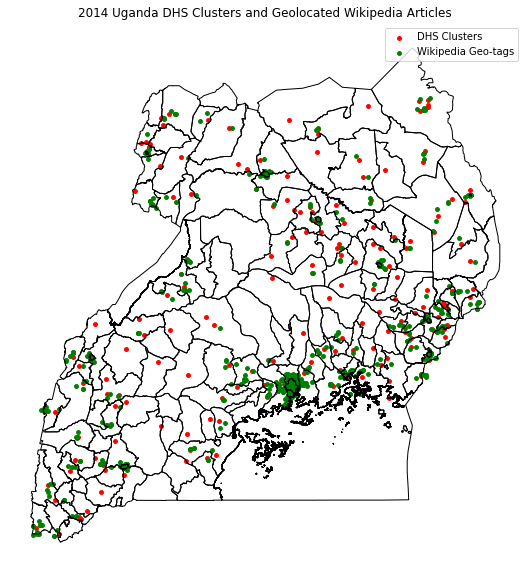

In [166]:
# Plot articles and clsuters

rwa_adm2 = gpd.read_file('data/Uganda/gadm36_UGA_shp/gadm36_UGA_2.shp') # load Rwanda Adm 2 shapefile (source: GADM repo)

# plot
fig, ax = plt.subplots(figsize=(10, 10))
plot = rwa_adm2.plot(ax=ax, color='none', edgecolor='black',zorder=2) # plot Adm 2 shapefile
plot = ax.scatter(uganda_clusts['longitude'], uganda_clusts['latitude'],
                  c='red', s=15, label='DHS Clusters') # plot survey clusters
ax.scatter(ug_article_df['longitude'], ug_article_df['latitude'],
                  c='green', s=15, label='Wikipedia Geo-tags') # plot survey clusters
ax.spines['left'].set_visible(False) # hide all axes
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
divider = make_axes_locatable(ax) # fix size of colormap to make it proportional to rest of graph
ax.set_title('2014 Uganda DHS Clusters and Geolocated Wikipedia Articles')
ax.legend()
plt.savefig('Uganda_Wiki_Articles_and_2014_DHS_Clusts.png')
plt.show()

### Nigeria

In [169]:
nigeria_clusts = dhs_clusts[(dhs_clusts['country']== 'nigeria') & (dhs_clusts['year']== 2010)]
nigeria_clusts = nigeria_clusts.rename(columns={'lat':'latitude', 'lon' : 'longitude'})

In [170]:
nigeria_clusts

,country,year,latitude,longitude,wealthpooled,households,urban_rural
11956,nigeria,2010,6.732517,8.002321,-0.642530,26,0
11957,nigeria,2010,7.247508,8.657348,-0.406471,25,0
11958,nigeria,2010,7.358567,8.489307,-0.420117,26,0
11959,nigeria,2010,6.864353,8.890684,-0.654294,26,0
11960,nigeria,2010,6.950979,8.345339,0.256707,25,0
...,...,...,...,...,...,...,...
12190,nigeria,2010,7.383139,3.964110,1.085200,26,0
12191,nigeria,2010,7.385056,3.894900,0.775521,26,1
12192,nigeria,2010,7.407212,3.906515,1.492821,26,1
12193,nigeria,2010,8.127695,4.241894,0.629930,24,1


In [171]:
ng_wiki_articles = {}
for i in tqdm(range(len(nigeria_clusts))):
    ng_wiki_articles.update(get_all_articles_near_clust(nigeria_clusts.iloc[i], ng_wiki_articles))

100%|██████████| 239/239 [14:43<00:00,  3.70s/it] 


In [172]:
ng_article_df = pd.DataFrame(ng_wiki_articles).T

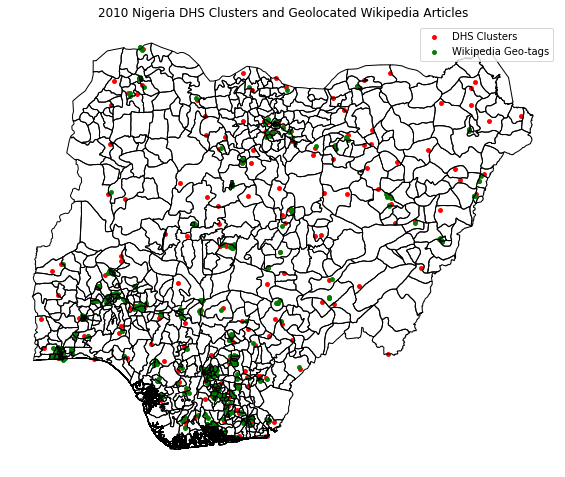

In [175]:
# Plot articles and clsuters

rwa_adm2 = gpd.read_file('data/Nigeria/gadm36_NGA_shp/gadm36_NGA_2.shp') # load Rwanda Adm 2 shapefile (source: GADM repo)

# plot
fig, ax = plt.subplots(figsize=(10, 10))
plot = rwa_adm2.plot(ax=ax, color='none', edgecolor='black',zorder=2) # plot Adm 2 shapefile
plot = ax.scatter(nigeria_clusts['longitude'], nigeria_clusts['latitude'],
                  c='red', s=15, label='DHS Clusters') # plot survey clusters
ax.scatter(ng_article_df['longitude'], ng_article_df['latitude'],
                  c='green', s=15, label='Wikipedia Geo-tags') # plot survey clusters
ax.spines['left'].set_visible(False) # hide all axes
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
divider = make_axes_locatable(ax) # fix size of colormap to make it proportional to rest of graph
ax.set_title('2010 Nigeria DHS Clusters and Geolocated Wikipedia Articles')
ax.legend()
plt.savefig('Nigeria_Wiki_Articles_and_2010_DHS_Clusts.png')
plt.show()

### Malawi

In [176]:
malawi_clusts = dhs_clusts[(dhs_clusts['country']== 'malawi') & (dhs_clusts['year']== 2014)]
malawi_clusts = malawi_clusts.rename(columns={'lat':'latitude', 'lon' : 'longitude'})

In [177]:
malawi_clusts

,country,year,latitude,longitude,wealthpooled,households,urban_rural
9497,malawi,2014,-9.530501,33.243335,-0.612943,24,0
9498,malawi,2014,-9.823194,33.378386,-0.545313,25,0
9499,malawi,2014,-10.111930,33.559969,-0.380111,25,0
9500,malawi,2014,-9.720551,33.288311,0.697978,25,1
9501,malawi,2014,-9.700572,33.259847,-0.190441,24,1
...,...,...,...,...,...,...,...
9632,malawi,2014,-15.829764,35.088025,0.654036,23,1
9633,malawi,2014,-15.853695,35.092018,0.203208,24,1
9634,malawi,2014,-15.825565,35.017303,0.737767,25,1
9635,malawi,2014,-15.842032,34.986195,0.138676,25,1


In [178]:
mw_wiki_articles = {}
for i in tqdm(range(len(malawi_clusts))):
    mw_wiki_articles.update(get_all_articles_near_clust(malawi_clusts.iloc[i], mw_wiki_articles))

100%|██████████| 140/140 [03:00<00:00,  1.29s/it]


In [179]:
mw_article_df = pd.DataFrame(mw_wiki_articles).T

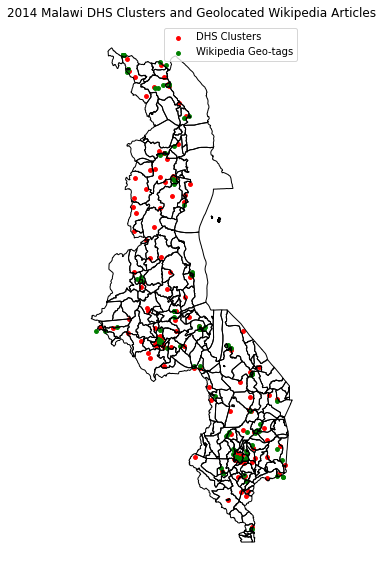

In [180]:
# Plot articles and clsuters

rwa_adm2 = gpd.read_file('data/Malawi/gadm36_MWI_shp/gadm36_MWI_2.shp') # load Rwanda Adm 2 shapefile (source: GADM repo)

# plot
fig, ax = plt.subplots(figsize=(10, 10))
plot = rwa_adm2.plot(ax=ax, color='none', edgecolor='black',zorder=2) # plot Adm 2 shapefile
plot = ax.scatter(malawi_clusts['longitude'], malawi_clusts['latitude'],
                  c='red', s=15, label='DHS Clusters') # plot survey clusters
ax.scatter(mw_article_df['longitude'], mw_article_df['latitude'],
                  c='green', s=15, label='Wikipedia Geo-tags') # plot survey clusters
ax.spines['left'].set_visible(False) # hide all axes
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
divider = make_axes_locatable(ax) # fix size of colormap to make it proportional to rest of graph
ax.set_title('2014 Malawi DHS Clusters and Geolocated Wikipedia Articles')
ax.legend()
plt.savefig('Malawi_Wiki_Articles_and_2014_DHS_Clusts.png')
plt.show()

### Tanzania

In [183]:
tanzania_clusts = dhs_clusts[(dhs_clusts['country']== 'tanzania') & (dhs_clusts['year']== 2010)]
tanzania_clusts = tanzania_clusts.rename(columns={'lat':'latitude', 'lon' : 'longitude'})

In [184]:
tanzania_clusts

,country,year,latitude,longitude,wealthpooled,households,urban_rural
15410,tanzania,2010,-6.138477,35.743701,0.176254,21,1
15411,tanzania,2010,-4.715211,36.007287,-0.612848,22,0
15412,tanzania,2010,-5.108290,36.301132,-0.548252,20,0
15413,tanzania,2010,-5.659221,35.389710,-1.144426,20,0
15414,tanzania,2010,-4.562516,35.756384,-0.746132,20,0
...,...,...,...,...,...,...,...
15863,tanzania,2010,-6.012883,39.220247,-0.206345,21,0
15864,tanzania,2010,-6.001724,39.246531,0.027277,22,0
15865,tanzania,2010,-5.928924,39.254502,-0.044876,22,0
15866,tanzania,2010,-5.985061,39.242211,-0.007156,22,0


In [185]:
tz_wiki_articles = {}
for i in tqdm(range(len(tanzania_clusts))):
    tz_wiki_articles.update(get_all_articles_near_clust(tanzania_clusts.iloc[i], tz_wiki_articles))

100%|██████████| 458/458 [13:06<00:00,  1.72s/it]  


In [186]:
tz_article_df = pd.DataFrame(tz_wiki_articles).T

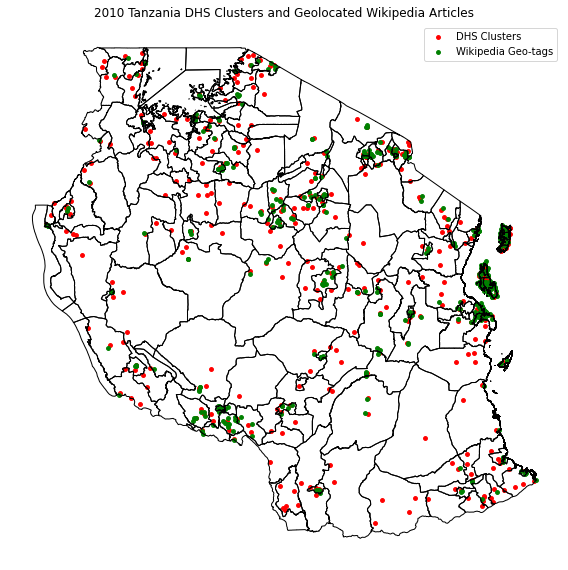

In [188]:
# Plot articles and clsuters

rwa_adm2 = gpd.read_file('data/Tanzania/gadm36_TZA_shp/gadm36_TZA_2.shp') # load Rwanda Adm 2 shapefile (source: GADM repo)

# plot
fig, ax = plt.subplots(figsize=(10, 10))
plot = rwa_adm2.plot(ax=ax, color='none', edgecolor='black',zorder=2) # plot Adm 2 shapefile
plot = ax.scatter(tanzania_clusts['longitude'], tanzania_clusts['latitude'],
                  c='red', s=15, label='DHS Clusters') # plot survey clusters
ax.scatter(tz_article_df['longitude'], tz_article_df['latitude'],
                  c='green', s=15, label='Wikipedia Geo-tags') # plot survey clusters
ax.spines['left'].set_visible(False) # hide all axes
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
divider = make_axes_locatable(ax) # fix size of colormap to make it proportional to rest of graph
ax.set_title('2010 Tanzania DHS Clusters and Geolocated Wikipedia Articles')
ax.legend()
plt.savefig('Tanzania_Wiki_Articles_and_2010_DHS_Clusts.png')
plt.show()

In [189]:
print(f"Num of Clusters and Articles")
print(f"Rwanda & {len(rwanda_cluster_avg_asset_2010)} & {len(wiki_articles)} \\\\")
print("\\hline")
print(f"Ghana & {len(ghana_clusts)} & {len(gh_wiki_articles)} \\\\")
print("\\hline")
print(f"Uganda & {len(uganda_clusts)} & {len(ug_wiki_articles)} \\\\")
print("\\hline")
print(f"Nigeria & {len(nigeria_clusts)} & {len(ng_wiki_articles)} \\\\")
print("\\hline")
print(f"Malawi & {len(malawi_clusts)} & {len(mw_wiki_articles)} \\\\")
print("\\hline")
print(f"Tanzania & {len(tanzania_clusts)} & {len(tz_wiki_articles)} \\\\")
print("\\hline")

Num of Clusters and Articles
Rwanda & 492 & 233 \\
\hline
Ghana & 422 & 906 \\
\hline
Uganda & 208 & 804 \\
\hline
Nigeria & 239 & 613 \\
\hline
Malawi & 140 & 125 \\
\hline
Tanzania & 458 & 573 \\
\hline
